In [6]:
import networkx as nx
import numpy as np
import scipy as sp
from numpy import linalg as LA
import pandas as pd
import csv
import matplotlib.pylab as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
caltech = nx.read_gml("/content/drive/MyDrive/TSP_Network_Graph/data/Caltech36.gml", destringizer=int)
mit=nx.read_gml("/content/drive/MyDrive/TSP_Network_Graph/data/MIT8.gml", destringizer=int)
jh=nx.read_gml("/content/drive/MyDrive/TSP_Network_Graph/data/Johns Hopkins55.gml", destringizer=int)
g_list = [caltech,mit, jh]
name_list = ['Caltech','MIT','Johns Hopkins']

In [53]:
def check_attribute_completeness_and_existence(graph, required_attributes):
    incomplete_attributes = {}
    missing_attributes = {}

    for node, attributes in graph.nodes(data=True):
        # 检查缺失的属性
        missing_attrs = [attr for attr in required_attributes if attr not in attributes]
        if missing_attrs:
            missing_attributes[node] = missing_attrs

        # 检查不完整的属性（存在但值为None）
        incomplete_attrs = [attr for attr, value in attributes.items() if value is None]
        if incomplete_attrs:
            incomplete_attributes[node] = incomplete_attrs

    return missing_attributes, incomplete_attributes

# 定义所有必需的属性名称
required_attributes = [
    'student_fac', 'gender', 'major_index', 'second_major',
    'dorm', 'year', 'high_school'
]

In [54]:
missing_attributes, incomplete_attributes = check_attribute_completeness_and_existence(caltech, required_attributes)

for node, attrs in missing_attributes.items():
    print(f"Node {node} is missing the following attributes: {attrs}")

for node, attrs in incomplete_attributes.items():
    print(f"Node {node} has incomplete attributes: {attrs}")



In [9]:
print(caltech.nodes()[0])

{'student_fac': 1, 'gender': 1, 'major_index': 199, 'second_major': 0, 'dorm': 169, 'year': 2008, 'high_school': 3387}


In [92]:
import torch
import torch.nn.functional as F
import networkx as nx
import numpy as np
from scipy import sparse

def label_propagation(graph, attribute, alpha=0.1, max_iter=1000, tol=1e-3, device='cuda'):

    is_labeled = {node: data.get(attribute) is not None for node, data in graph.nodes(data=True)}


    labels = {node: data[attribute] for node, data in graph.nodes(data=True) if is_labeled[node]}


    unique_labels = list(set(labels.values()))
    label_mapping = {label: index for index, label in enumerate(unique_labels)}


    num_nodes = graph.number_of_nodes()
    num_labels = len(unique_labels)
    labels_pred = torch.zeros(num_nodes, num_labels, device=device)


    for node, label in labels.items():
        node_index = list(graph.nodes()).index(node)
        labels_pred[node_index, label_mapping[label]] = 1


    A = nx.adjacency_matrix(graph, nodelist=graph.nodes())
    D = sparse.diags(1.0 / np.array(A.sum(axis=1)).flatten(), 0)
    T = D.dot(A)


    T_coo = T.tocoo()
    values = T_coo.data
    indices = np.vstack((T_coo.row, T_coo.col))
    i = torch.LongTensor(indices).to(device)
    v = torch.FloatTensor(values).to(device)
    shape = T_coo.shape
    T = torch.sparse.FloatTensor(i, v, torch.Size(shape)).to(device)



    F = labels_pred.clone()
    for iteration in range(max_iter):
        F_prev = F.clone()
        F = alpha * torch.sparse.mm(T, F) + (1 - alpha) * labels_pred

        if torch.norm(F - F_prev) < tol:
            break


    labels_pred = torch.argmax(F, dim=1).cpu().numpy()
    predicted_labels = {node: unique_labels[labels_pred[i]] for i, node in enumerate(graph.nodes()) if not is_labeled[node]}

    return predicted_labels

In [36]:
def remove_attributes_values_from_fraction_of_nodes(graph, fraction):
    # 创建图的深拷贝，以便修改节点属性而不影响原始图
    modified_graph = graph.copy()
    removed_attributes = {}

    # 获取所有节点，转换为列表
    all_nodes = list(modified_graph.nodes())
    # 计算要清空属性值的节点数量
    num_nodes = int(len(all_nodes) * fraction)
    # 随机选择要清空属性值的节点
    nodes_to_clear_attributes = random.sample(all_nodes, num_nodes)

    for node in nodes_to_clear_attributes:
        # 记录节点的所有属性
        removed_attributes[node] = dict(modified_graph.nodes[node])
        # 清空节点的所有属性值但保留属性名
        for attr in modified_graph.nodes[node]:
            modified_graph.nodes[node][attr] = None  # 或者使用其他“空”值，如 '' 或 0

    return modified_graph, removed_attributes

def extract_attribute_values(node_attribute_dict, attribute):
    return {node: attributes[attribute] for node, attributes in node_attribute_dict.items() if attribute in attributes}


In [75]:
import random
import numpy as np
import networkx as nx
from sklearn.metrics import accuracy_score

def calculate_accuracy(true_values, predictions):

    y_true = [true_values[node] for node in predictions]
    y_pred = [predictions[node] for node in predictions]
    return accuracy_score(y_true, y_pred)

In [93]:
G = caltech
fraction_of_nodes = 0.1  # 比例：10%
miss_attribute = 'major_index'

residual_graph, removed_attribute_values = remove_attributes_values_from_fraction_of_nodes(G, fraction_of_nodes)

# 执行标签传播算法
predictions = label_propagation(residual_graph, miss_attribute , 0.1, 1000, 1e-3, 'cuda')

true_values = extract_attribute_values(removed_attribute_values, miss_attribute)

In [ ]:
def run_label_propagation(G, fraction_of_nodes, miss_attribute):
    # 移除指定比例的节点属性
    residual_graph, removed_attribute_values = remove_attributes_values_from_fraction_of_nodes(G, fraction_of_nodes)

    # 执行标签传播算法
    predictions = label_propagation(residual_graph, miss_attribute, 0.1, 1000, 1e-3, 'cuda')

    # 提取被移除属性的真实值
    true_values = extract_attribute_values(removed_attribute_values, miss_attribute)

    return true_values, predictions

In [82]:
file_names_list = ['Caltech36.gml',
  'Reed98.gml',
  'Haverford76.gml',
  'Simmons81.gml',
  'Swarthmore42.gml',
  'Amherst41.gml',
  'Bowdoin47.gml',
  'Hamilton46.gml',
  'Trinity100.gml',
  'USFCA72.gml',
  'Williams40.gml',
  'Oberlin44.gml',
  'Wellesley22.gml',
  'Smith60.gml',
  'Vassar85.gml']



g_all_list = []

for i in file_names_list:
  g_all_list.append(nx.read_gml("/content/drive/MyDrive/TSP_Network_Graph/data/"+str(i), destringizer=int))


In [112]:
for i in range(len(g_all_list)):
    g_all_list[i] = g_all_list[i].subgraph(max(nx.connected_components(g_all_list[i]), key=len)).copy()



In [116]:
for i in range(len(g_all_list)):
  print(nx.number_connected_components(g_all_list[i]))

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [ ]:
print(removed_attribute_values,predictions)


true_values

In [74]:

# 计算准确率
accuracy = calculate_accuracy(true_values, predictions)
print(f"The accuracy of the label propagation prediction is: {accuracy:.2f}")

The accuracy of the label propagation prediction is: 0.70


In [117]:
import networkx as nx
from sklearn.metrics import accuracy_score

def calculate_accuracy(true_values, predictions):
    common_nodes = set(true_values.keys()).intersection(set(predictions.keys()))
    y_true = [true_values[node] for node in common_nodes]
    y_pred = [predictions[node] for node in common_nodes]
    return accuracy_score(y_true, y_pred)

def generate_table_for_graphs(G_list, fraction_of_nodes_list, miss_attribute_list, file_names_list):

    assert len(G_list) == len(file_names_list)


    results = {name: {attr: [] for attr in miss_attribute_list} for name in file_names_list}

    original_results = {name: {attr: [] for attr in miss_attribute_list} for name in file_names_list}


    for G, name in zip(G_list, file_names_list):
        print(f"Processing graph: {name}")


        for fraction in fraction_of_nodes_list:


            for attribute in miss_attribute_list:

                residual_graph, removed_attribute_values = remove_attributes_values_from_fraction_of_nodes(G, fraction)
                predictions = label_propagation(residual_graph, attribute, 0.1, 1000, 1e-3, 'cuda')
                true_values = extract_attribute_values(removed_attribute_values, attribute)

                accuracy = calculate_accuracy(true_values, predictions)

                results[name][attribute].append(accuracy)

                original_results[name][attribute].append((true_values, predictions))

    # 打印表格
    print("Table 1: Accuracy of the label propagation algorithm")
    print(f"{'Attribute':<10}", end="")
    for fraction in fraction_of_nodes_list:
        print(f"{fraction:<10}", end="")
    print()
    for name, attrs in results.items():
        print(f"{name:<10}\n", end="")
        for attr, accuracies in attrs.items():
            print(f"{attr:<10}", end="")
            for acc in accuracies:
                print(f"{acc:.3f}     ", end="")
            print()
        print()

    # 返回包含准确率和原始结果的字典
    return results, original_results
fraction_of_nodes = [0.1,0.2,0.3]
miss_attribute = ['dorm','major_index','gender']
# 调用函数
results,original_results  = generate_table_for_graphs(g_all_list, fraction_of_nodes, miss_attribute, file_names_list)


Processing graph: Caltech36.gml
Processing graph: Reed98.gml
Processing graph: Haverford76.gml
Processing graph: Simmons81.gml
Processing graph: Swarthmore42.gml
Processing graph: Amherst41.gml
Processing graph: Bowdoin47.gml
Processing graph: Hamilton46.gml
Processing graph: Trinity100.gml
Processing graph: USFCA72.gml
Processing graph: Williams40.gml
Processing graph: Oberlin44.gml
Processing graph: Wellesley22.gml
Processing graph: Smith60.gml
Processing graph: Vassar85.gml
Table 1: Accuracy of the label propagation algorithm
Attribute 0.1       0.2       0.3       
Caltech36.gml
dorm      0.684     0.697     0.759     
major_index0.118     0.217     0.219     
gender    0.592     0.559     0.610     

Reed98.gml
dorm      0.625     0.630     0.615     
major_index0.260     0.286     0.257     
gender    0.552     0.521     0.552     

Haverford76.gml
dorm      0.583     0.536     0.510     
major_index0.347     0.298     0.316     
gender    0.597     0.640     0.605     

Simmons8

In [118]:
g = nx.read_gml("/content/drive/MyDrive/TSP_Network_Graph/data/Duke14.gml", destringizer=int)
g = [g.subgraph(max(nx.connected_components(g), key=len)).copy()]
name = ['duke']
result,o_result = generate_table_for_graphs(g, fraction_of_nodes, miss_attribute, name)

Processing graph: duke
Table 1: Accuracy of the label propagation algorithm
Attribute 0.1       0.2       0.3       
duke      
dorm      0.499     0.472     0.489     
major_index0.284     0.284     0.280     
gender    0.627     0.624     0.611     



In [119]:
from sklearn.metrics import f1_score

def calculate_weighted_f1_score(original_results):
    f1_scores = {}

    for graph_name, graph_data in original_results.items():
        f1_scores[graph_name] = {}
        for attribute, values in graph_data.items():

            f1_scores_attribute = []
            for true_values, predictions in values:

                y_true = list(true_values.values())
                y_pred = list(predictions.values())

                f1 = f1_score(y_true, y_pred, average='weighted')
                f1_scores_attribute.append(f1)

            f1_scores[graph_name][attribute] = f1_scores_attribute

    return f1_scores
f1_scores = calculate_weighted_f1_score(original_results)

print(f1_scores)

{'Caltech36.gml': {'dorm': [0.14573197700132684, 0.13078035697344012, 0.12985497712625918], 'major_index': [0.030425162004109375, 0.0693155287842645, 0.07131463849769396], 'gender': [0.5252145308924485, 0.42287385129490396, 0.5577809272262665]}, 'Reed98.gml': {'dorm': [0.3246386630532972, 0.28915662650602403, 0.30526800092017486], 'major_index': [0.039033543341579054, 0.05194398705428116, 0.09458568132755849], 'gender': [0.45420392449080965, 0.41494984567901233, 0.44091132818415874]}, 'Haverford76.gml': {'dorm': [0.16050685425685426, 0.1735794957990856, 0.1981004297609765], 'major_index': [0.15085077691525378, 0.09575532408701846, 0.11336771915026904], 'gender': [0.38737373737373737, 0.443727913310653, 0.45650735650599533]}, 'Simmons81.gml': {'dorm': [0.22728108903605596, 0.21475694847267726, 0.2442759850386727], 'major_index': [0.0672021936095065, 0.06429000543614158, 0.07970078596132607], 'gender': [0.8824389129938343, 0.8807832641343261, 0.9190397350993377]}, 'Swarthmore42.gml': {'d

In [120]:

def print_f1_scores_table(f1_scores, fraction_of_nodes_list, miss_attribute_list):
    print("Table: Weighted F1 Score of the label propagation algorithm")
    header = "Attribute" + " " * (15 - len("Attribute"))
    for fraction in fraction_of_nodes_list:
        header += f"{fraction:<15}"
    print(header)

    for graph_name, graph_data in f1_scores.items():
        print(f"{graph_name}")
        for attribute in miss_attribute_list:
            attr_scores = graph_data.get(attribute, [])
            row = f"{attribute:<15}"
            for score in attr_scores:
                row += f"{score:.3f}{' ' * 10}"
            print(row)
        print()

In [121]:
print_f1_scores_table(f1_scores, fraction_of_nodes, miss_attribute)

Table: Weighted F1 Score of the label propagation algorithm
Attribute      0.1            0.2            0.3            
Caltech36.gml
dorm           0.146          0.131          0.130          
major_index    0.030          0.069          0.071          
gender         0.525          0.423          0.558          

Reed98.gml
dorm           0.325          0.289          0.305          
major_index    0.039          0.052          0.095          
gender         0.454          0.415          0.441          

Haverford76.gml
dorm           0.161          0.174          0.198          
major_index    0.151          0.096          0.113          
gender         0.387          0.444          0.457          

Simmons81.gml
dorm           0.227          0.215          0.244          
major_index    0.067          0.064          0.080          
gender         0.882          0.881          0.919          

Swarthmore42.gml
dorm           0.122          0.212          0.155          
major_inde

question 6

In [128]:
gender_data = []
for g in g_all_list:
  gender_dict = {node: data['gender'] for node, data in g.nodes(data=True)}
  gender_data.append(gender_dict)


In [134]:
g_all_list[0].nodes()[1]['gender']

1

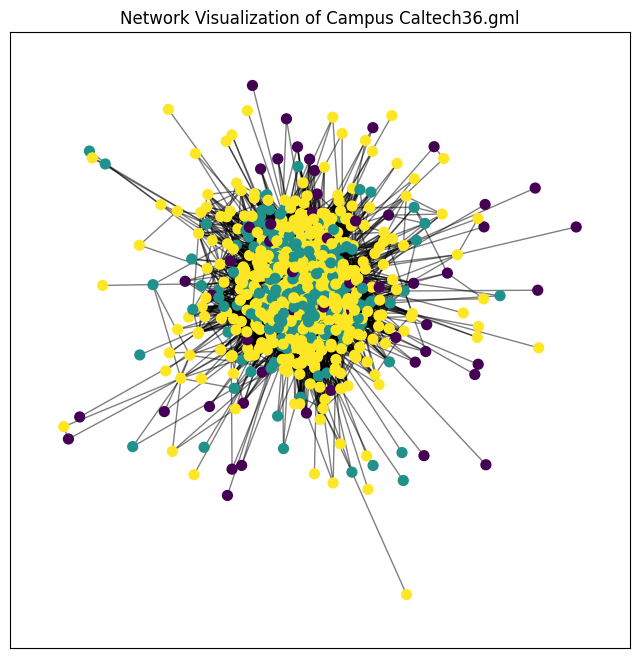

Campus Caltech36.gml, Community 0:
Gender distribution: 6 Unknown, 42 Male, 71 Female
Total members: 119
Proportion of Unknown: 0.05
Proportion of Male: 0.35
Proportion of Female: 0.60

Campus Caltech36.gml, Community 2:
Gender distribution: 9 Unknown, 22 Male, 49 Female
Total members: 80
Proportion of Unknown: 0.11
Proportion of Male: 0.28
Proportion of Female: 0.61

Campus Caltech36.gml, Community 5:
Gender distribution: 9 Unknown, 47 Male, 88 Female
Total members: 144
Proportion of Unknown: 0.06
Proportion of Male: 0.33
Proportion of Female: 0.61

Campus Caltech36.gml, Community 3:
Gender distribution: 6 Unknown, 22 Male, 50 Female
Total members: 78
Proportion of Unknown: 0.08
Proportion of Male: 0.28
Proportion of Female: 0.64

Campus Caltech36.gml, Community 1:
Gender distribution: 14 Unknown, 22 Male, 80 Female
Total members: 116
Proportion of Unknown: 0.12
Proportion of Male: 0.19
Proportion of Female: 0.69

Campus Caltech36.gml, Community 6:
Gender distribution: 8 Unknown, 39 M

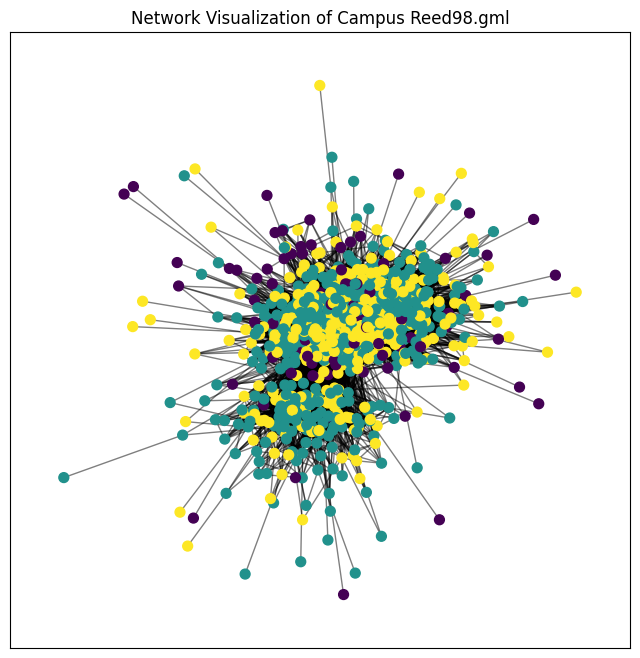

Campus Reed98.gml, Community 4:
Gender distribution: 23 Unknown, 123 Male, 89 Female
Total members: 235
Proportion of Unknown: 0.10
Proportion of Male: 0.52
Proportion of Female: 0.38

Campus Reed98.gml, Community 1:
Gender distribution: 24 Unknown, 105 Male, 68 Female
Total members: 197
Proportion of Unknown: 0.12
Proportion of Male: 0.53
Proportion of Female: 0.35

Campus Reed98.gml, Community 2:
Gender distribution: 19 Unknown, 53 Male, 70 Female
Total members: 142
Proportion of Unknown: 0.13
Proportion of Male: 0.37
Proportion of Female: 0.49

Campus Reed98.gml, Community 3:
Gender distribution: 6 Unknown, 114 Male, 58 Female
Total members: 178
Proportion of Unknown: 0.03
Proportion of Male: 0.64
Proportion of Female: 0.33

Campus Reed98.gml, Community 5:
Gender distribution: 7 Unknown, 33 Male, 20 Female
Total members: 60
Proportion of Unknown: 0.12
Proportion of Male: 0.55
Proportion of Female: 0.33

Campus Reed98.gml, Community 0:
Gender distribution: 18 Unknown, 76 Male, 56 Fem

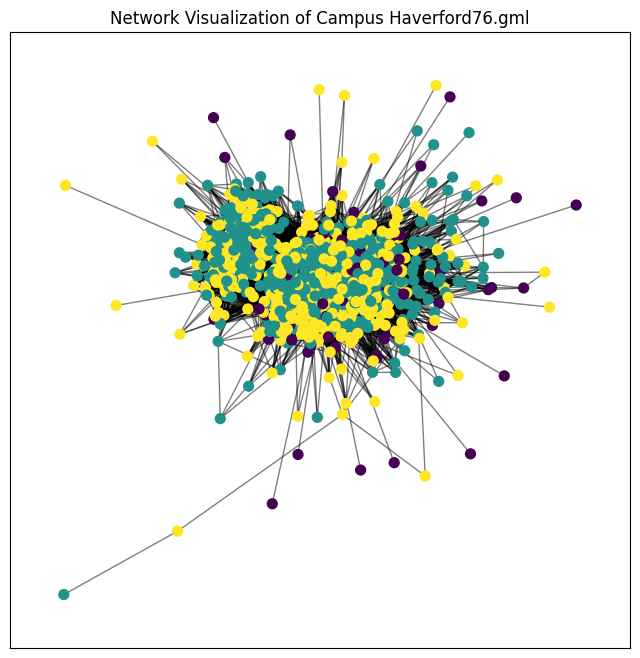

Campus Haverford76.gml, Community 0:
Gender distribution: 39 Unknown, 197 Male, 135 Female
Total members: 371
Proportion of Unknown: 0.11
Proportion of Male: 0.53
Proportion of Female: 0.36

Campus Haverford76.gml, Community 1:
Gender distribution: 23 Unknown, 175 Male, 126 Female
Total members: 324
Proportion of Unknown: 0.07
Proportion of Male: 0.54
Proportion of Female: 0.39

Campus Haverford76.gml, Community 2:
Gender distribution: 18 Unknown, 135 Male, 115 Female
Total members: 268
Proportion of Unknown: 0.07
Proportion of Male: 0.50
Proportion of Female: 0.43

Campus Haverford76.gml, Community 3:
Gender distribution: 2 Unknown, 159 Male, 130 Female
Total members: 291
Proportion of Unknown: 0.01
Proportion of Male: 0.55
Proportion of Female: 0.45

Campus Haverford76.gml, Community 4:
Gender distribution: 14 Unknown, 66 Male, 112 Female
Total members: 192
Proportion of Unknown: 0.07
Proportion of Male: 0.34
Proportion of Female: 0.58



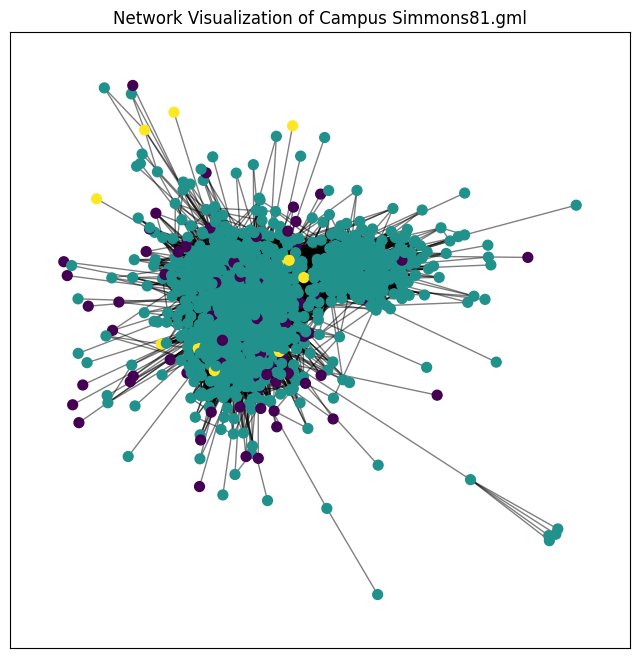

Campus Simmons81.gml, Community 0:
Gender distribution: 26 Unknown, 319 Male, 6 Female
Total members: 351
Proportion of Unknown: 0.07
Proportion of Male: 0.91
Proportion of Female: 0.02

Campus Simmons81.gml, Community 1:
Gender distribution: 41 Unknown, 374 Male, 4 Female
Total members: 419
Proportion of Unknown: 0.10
Proportion of Male: 0.89
Proportion of Female: 0.01

Campus Simmons81.gml, Community 2:
Gender distribution: 20 Unknown, 363 Male, 1 Female
Total members: 384
Proportion of Unknown: 0.05
Proportion of Male: 0.95
Proportion of Female: 0.00

Campus Simmons81.gml, Community 3:
Gender distribution: 5 Unknown, 307 Male, 0 Female
Total members: 312
Proportion of Unknown: 0.02
Proportion of Male: 0.98
Proportion of Female: 0.00

Campus Simmons81.gml, Community 5:
Gender distribution: 2 Unknown, 11 Male, 3 Female
Total members: 16
Proportion of Unknown: 0.12
Proportion of Male: 0.69
Proportion of Female: 0.19

Campus Simmons81.gml, Community 6:
Gender distribution: 1 Unknown, 22

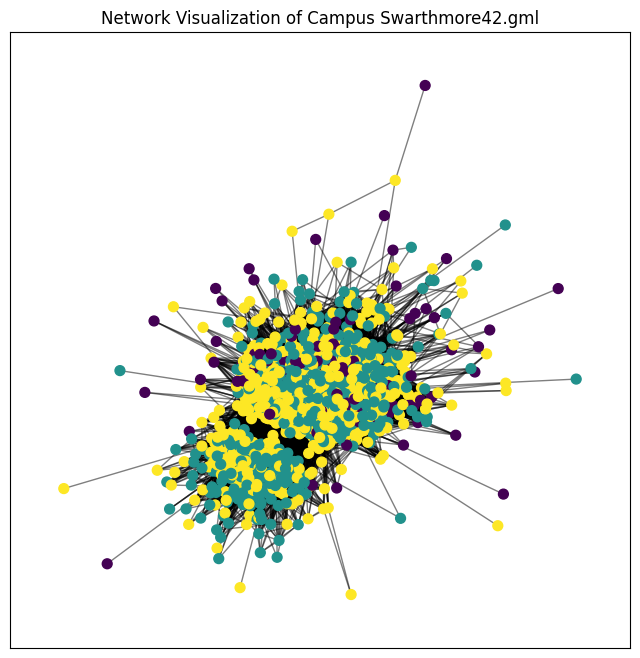

Campus Swarthmore42.gml, Community 0:
Gender distribution: 28 Unknown, 108 Male, 94 Female
Total members: 230
Proportion of Unknown: 0.12
Proportion of Male: 0.47
Proportion of Female: 0.41

Campus Swarthmore42.gml, Community 1:
Gender distribution: 20 Unknown, 136 Male, 137 Female
Total members: 293
Proportion of Unknown: 0.07
Proportion of Male: 0.46
Proportion of Female: 0.47

Campus Swarthmore42.gml, Community 2:
Gender distribution: 33 Unknown, 108 Male, 168 Female
Total members: 309
Proportion of Unknown: 0.11
Proportion of Male: 0.35
Proportion of Female: 0.54

Campus Swarthmore42.gml, Community 3:
Gender distribution: 3 Unknown, 162 Male, 137 Female
Total members: 302
Proportion of Unknown: 0.01
Proportion of Male: 0.54
Proportion of Female: 0.45

Campus Swarthmore42.gml, Community 4:
Gender distribution: 16 Unknown, 72 Male, 84 Female
Total members: 172
Proportion of Unknown: 0.09
Proportion of Male: 0.42
Proportion of Female: 0.49

Campus Swarthmore42.gml, Community 5:
Gender

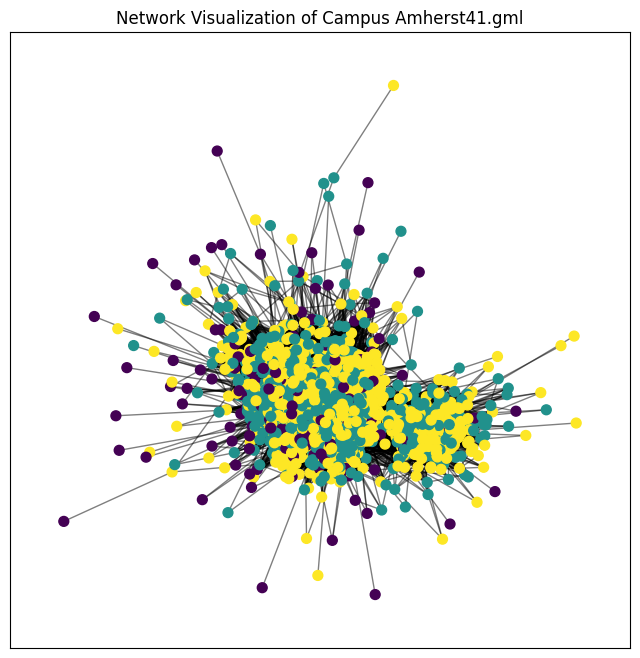

Campus Amherst41.gml, Community 0:
Gender distribution: 27 Unknown, 177 Male, 183 Female
Total members: 387
Proportion of Unknown: 0.07
Proportion of Male: 0.46
Proportion of Female: 0.47

Campus Amherst41.gml, Community 1:
Gender distribution: 18 Unknown, 104 Male, 112 Female
Total members: 234
Proportion of Unknown: 0.08
Proportion of Male: 0.44
Proportion of Female: 0.48

Campus Amherst41.gml, Community 2:
Gender distribution: 46 Unknown, 152 Male, 206 Female
Total members: 404
Proportion of Unknown: 0.11
Proportion of Male: 0.38
Proportion of Female: 0.51

Campus Amherst41.gml, Community 3:
Gender distribution: 7 Unknown, 195 Male, 184 Female
Total members: 386
Proportion of Unknown: 0.02
Proportion of Male: 0.51
Proportion of Female: 0.48

Campus Amherst41.gml, Community 6:
Gender distribution: 86 Unknown, 293 Male, 258 Female
Total members: 637
Proportion of Unknown: 0.14
Proportion of Male: 0.46
Proportion of Female: 0.41

Campus Amherst41.gml, Community 4:
Gender distribution: 

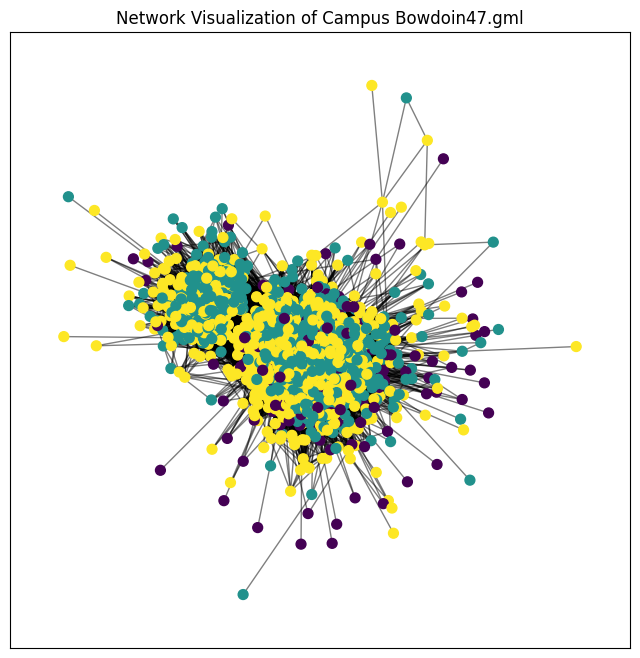

Campus Bowdoin47.gml, Community 0:
Gender distribution: 70 Unknown, 257 Male, 245 Female
Total members: 572
Proportion of Unknown: 0.12
Proportion of Male: 0.45
Proportion of Female: 0.43

Campus Bowdoin47.gml, Community 1:
Gender distribution: 8 Unknown, 230 Male, 185 Female
Total members: 423
Proportion of Unknown: 0.02
Proportion of Male: 0.54
Proportion of Female: 0.44

Campus Bowdoin47.gml, Community 2:
Gender distribution: 35 Unknown, 197 Male, 205 Female
Total members: 437
Proportion of Unknown: 0.08
Proportion of Male: 0.45
Proportion of Female: 0.47

Campus Bowdoin47.gml, Community 3:
Gender distribution: 26 Unknown, 145 Male, 122 Female
Total members: 293
Proportion of Unknown: 0.09
Proportion of Male: 0.49
Proportion of Female: 0.42

Campus Bowdoin47.gml, Community 4:
Gender distribution: 11 Unknown, 49 Male, 43 Female
Total members: 103
Proportion of Unknown: 0.11
Proportion of Male: 0.48
Proportion of Female: 0.42

Campus Bowdoin47.gml, Community 5:
Gender distribution: 48

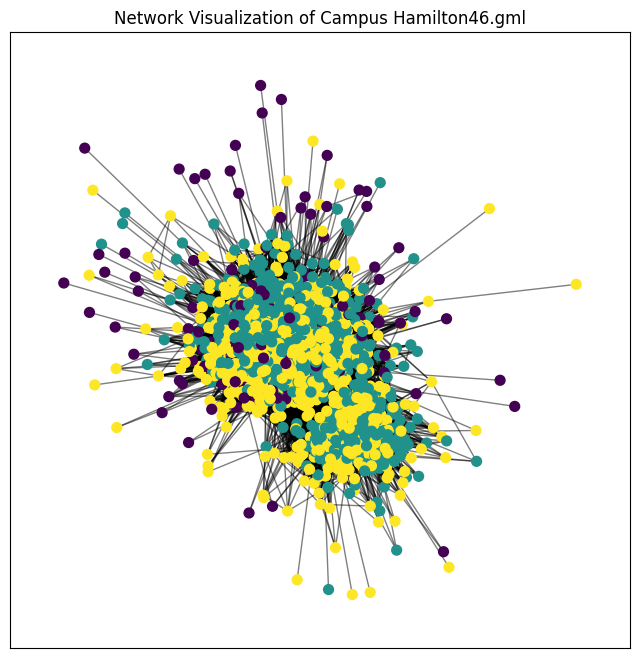

Campus Hamilton46.gml, Community 0:
Gender distribution: 4 Unknown, 238 Male, 213 Female
Total members: 455
Proportion of Unknown: 0.01
Proportion of Male: 0.52
Proportion of Female: 0.47

Campus Hamilton46.gml, Community 3:
Gender distribution: 90 Unknown, 367 Male, 341 Female
Total members: 798
Proportion of Unknown: 0.11
Proportion of Male: 0.46
Proportion of Female: 0.43

Campus Hamilton46.gml, Community 2:
Gender distribution: 42 Unknown, 198 Male, 172 Female
Total members: 412
Proportion of Unknown: 0.10
Proportion of Male: 0.48
Proportion of Female: 0.42

Campus Hamilton46.gml, Community 4:
Gender distribution: 27 Unknown, 210 Male, 176 Female
Total members: 413
Proportion of Unknown: 0.07
Proportion of Male: 0.51
Proportion of Female: 0.43

Campus Hamilton46.gml, Community 1:
Gender distribution: 20 Unknown, 118 Male, 96 Female
Total members: 234
Proportion of Unknown: 0.09
Proportion of Male: 0.50
Proportion of Female: 0.41



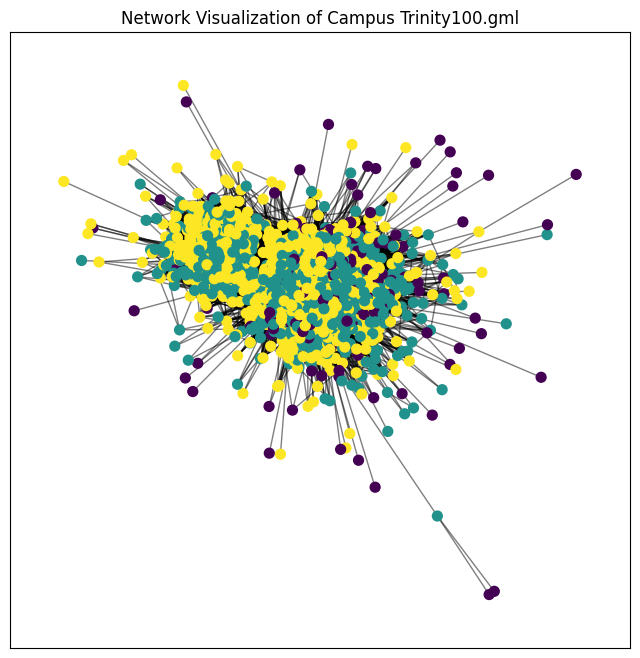

Campus Trinity100.gml, Community 0:
Gender distribution: 34 Unknown, 231 Male, 226 Female
Total members: 491
Proportion of Unknown: 0.07
Proportion of Male: 0.47
Proportion of Female: 0.46

Campus Trinity100.gml, Community 3:
Gender distribution: 112 Unknown, 307 Male, 350 Female
Total members: 769
Proportion of Unknown: 0.15
Proportion of Male: 0.40
Proportion of Female: 0.46

Campus Trinity100.gml, Community 2:
Gender distribution: 7 Unknown, 253 Male, 228 Female
Total members: 488
Proportion of Unknown: 0.01
Proportion of Male: 0.52
Proportion of Female: 0.47

Campus Trinity100.gml, Community 6:
Gender distribution: 16 Unknown, 93 Male, 67 Female
Total members: 176
Proportion of Unknown: 0.09
Proportion of Male: 0.53
Proportion of Female: 0.38

Campus Trinity100.gml, Community 4:
Gender distribution: 55 Unknown, 272 Male, 235 Female
Total members: 562
Proportion of Unknown: 0.10
Proportion of Male: 0.48
Proportion of Female: 0.42

Campus Trinity100.gml, Community 1:
Gender distribut

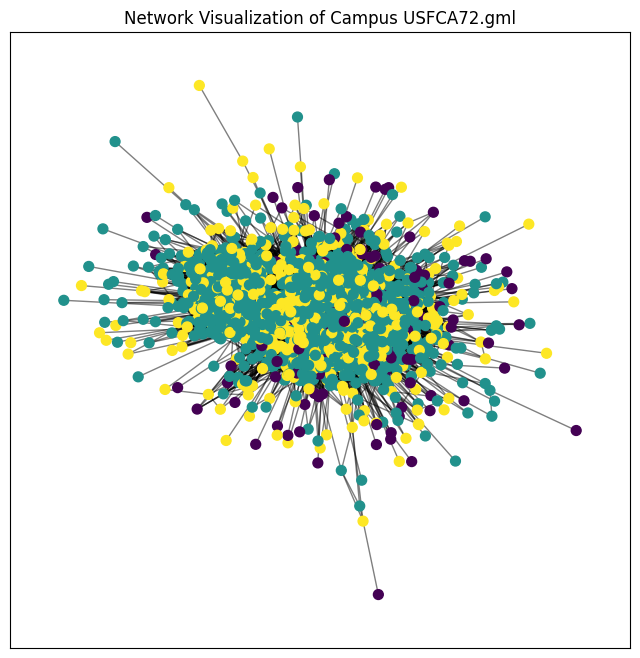

Campus USFCA72.gml, Community 0:
Gender distribution: 31 Unknown, 285 Male, 120 Female
Total members: 436
Proportion of Unknown: 0.07
Proportion of Male: 0.65
Proportion of Female: 0.28

Campus USFCA72.gml, Community 1:
Gender distribution: 5 Unknown, 406 Male, 150 Female
Total members: 561
Proportion of Unknown: 0.01
Proportion of Male: 0.72
Proportion of Female: 0.27

Campus USFCA72.gml, Community 2:
Gender distribution: 31 Unknown, 205 Male, 70 Female
Total members: 306
Proportion of Unknown: 0.10
Proportion of Male: 0.67
Proportion of Female: 0.23

Campus USFCA72.gml, Community 3:
Gender distribution: 24 Unknown, 307 Male, 180 Female
Total members: 511
Proportion of Unknown: 0.05
Proportion of Male: 0.60
Proportion of Female: 0.35

Campus USFCA72.gml, Community 6:
Gender distribution: 36 Unknown, 188 Male, 156 Female
Total members: 380
Proportion of Unknown: 0.09
Proportion of Male: 0.49
Proportion of Female: 0.41

Campus USFCA72.gml, Community 5:
Gender distribution: 42 Unknown, 2

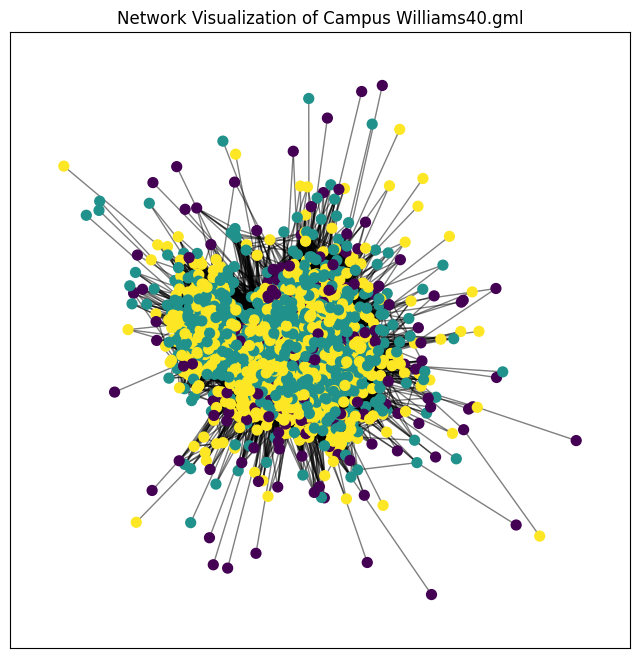

Campus Williams40.gml, Community 0:
Gender distribution: 56 Unknown, 274 Male, 250 Female
Total members: 580
Proportion of Unknown: 0.10
Proportion of Male: 0.47
Proportion of Female: 0.43

Campus Williams40.gml, Community 1:
Gender distribution: 22 Unknown, 159 Male, 120 Female
Total members: 301
Proportion of Unknown: 0.07
Proportion of Male: 0.53
Proportion of Female: 0.40

Campus Williams40.gml, Community 2:
Gender distribution: 60 Unknown, 255 Male, 260 Female
Total members: 575
Proportion of Unknown: 0.10
Proportion of Male: 0.44
Proportion of Female: 0.45

Campus Williams40.gml, Community 3:
Gender distribution: 9 Unknown, 243 Male, 210 Female
Total members: 462
Proportion of Unknown: 0.02
Proportion of Male: 0.53
Proportion of Female: 0.45

Campus Williams40.gml, Community 4:
Gender distribution: 34 Unknown, 108 Male, 123 Female
Total members: 265
Proportion of Unknown: 0.13
Proportion of Male: 0.41
Proportion of Female: 0.46

Campus Williams40.gml, Community 5:
Gender distribu

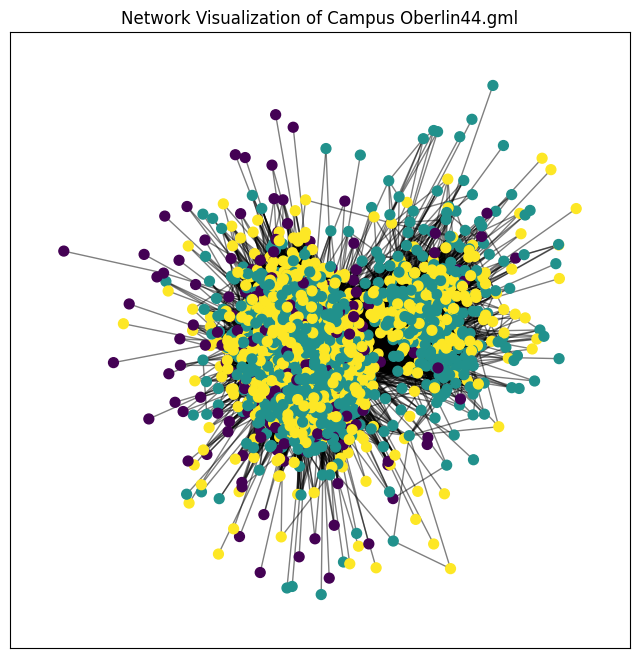

Campus Oberlin44.gml, Community 4:
Gender distribution: 93 Unknown, 393 Male, 277 Female
Total members: 763
Proportion of Unknown: 0.12
Proportion of Male: 0.52
Proportion of Female: 0.36

Campus Oberlin44.gml, Community 0:
Gender distribution: 33 Unknown, 201 Male, 205 Female
Total members: 439
Proportion of Unknown: 0.08
Proportion of Male: 0.46
Proportion of Female: 0.47

Campus Oberlin44.gml, Community 2:
Gender distribution: 59 Unknown, 229 Male, 201 Female
Total members: 489
Proportion of Unknown: 0.12
Proportion of Male: 0.47
Proportion of Female: 0.41

Campus Oberlin44.gml, Community 1:
Gender distribution: 32 Unknown, 233 Male, 168 Female
Total members: 433
Proportion of Unknown: 0.07
Proportion of Male: 0.54
Proportion of Female: 0.39

Campus Oberlin44.gml, Community 5:
Gender distribution: 11 Unknown, 249 Male, 161 Female
Total members: 421
Proportion of Unknown: 0.03
Proportion of Male: 0.59
Proportion of Female: 0.38

Campus Oberlin44.gml, Community 3:
Gender distribution:

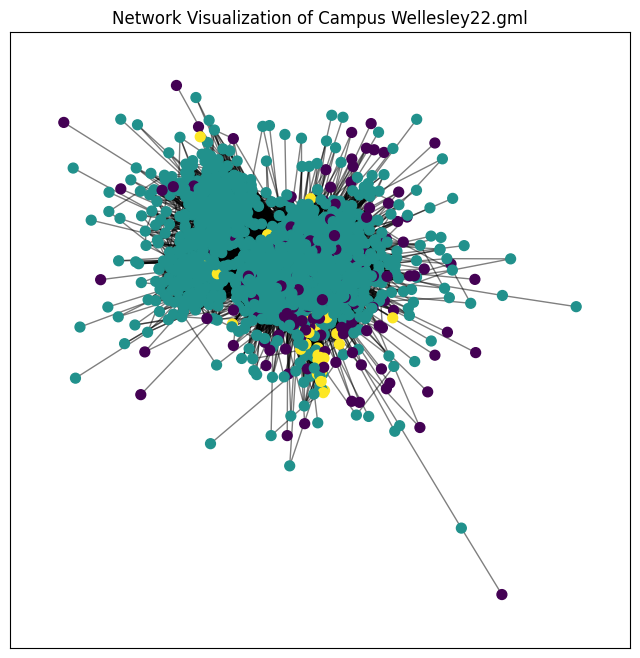

Campus Wellesley22.gml, Community 0:
Gender distribution: 47 Unknown, 583 Male, 5 Female
Total members: 635
Proportion of Unknown: 0.07
Proportion of Male: 0.92
Proportion of Female: 0.01

Campus Wellesley22.gml, Community 1:
Gender distribution: 76 Unknown, 435 Male, 3 Female
Total members: 514
Proportion of Unknown: 0.15
Proportion of Male: 0.85
Proportion of Female: 0.01

Campus Wellesley22.gml, Community 2:
Gender distribution: 53 Unknown, 501 Male, 1 Female
Total members: 555
Proportion of Unknown: 0.10
Proportion of Male: 0.90
Proportion of Female: 0.00

Campus Wellesley22.gml, Community 3:
Gender distribution: 70 Unknown, 465 Male, 2 Female
Total members: 537
Proportion of Unknown: 0.13
Proportion of Male: 0.87
Proportion of Female: 0.00

Campus Wellesley22.gml, Community 4:
Gender distribution: 11 Unknown, 166 Male, 0 Female
Total members: 177
Proportion of Unknown: 0.06
Proportion of Male: 0.94
Proportion of Female: 0.00

Campus Wellesley22.gml, Community 5:
Gender distributio

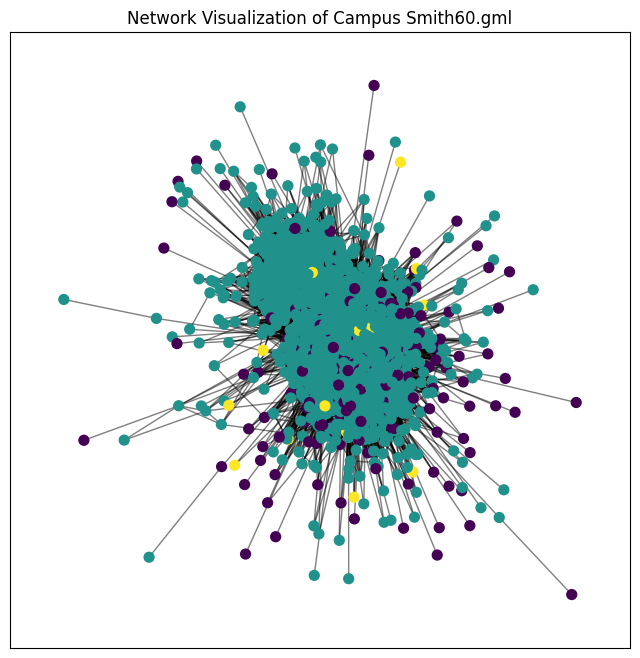

Campus Smith60.gml, Community 17:
Gender distribution: 59 Unknown, 234 Male, 6 Female
Total members: 299
Proportion of Unknown: 0.20
Proportion of Male: 0.78
Proportion of Female: 0.02

Campus Smith60.gml, Community 1:
Gender distribution: 24 Unknown, 152 Male, 4 Female
Total members: 180
Proportion of Unknown: 0.13
Proportion of Male: 0.84
Proportion of Female: 0.02

Campus Smith60.gml, Community 3:
Gender distribution: 61 Unknown, 416 Male, 1 Female
Total members: 478
Proportion of Unknown: 0.13
Proportion of Male: 0.87
Proportion of Female: 0.00

Campus Smith60.gml, Community 14:
Gender distribution: 11 Unknown, 78 Male, 0 Female
Total members: 89
Proportion of Unknown: 0.12
Proportion of Male: 0.88
Proportion of Female: 0.00

Campus Smith60.gml, Community 5:
Gender distribution: 5 Unknown, 75 Male, 3 Female
Total members: 83
Proportion of Unknown: 0.06
Proportion of Male: 0.90
Proportion of Female: 0.04

Campus Smith60.gml, Community 4:
Gender distribution: 12 Unknown, 385 Male, 1 

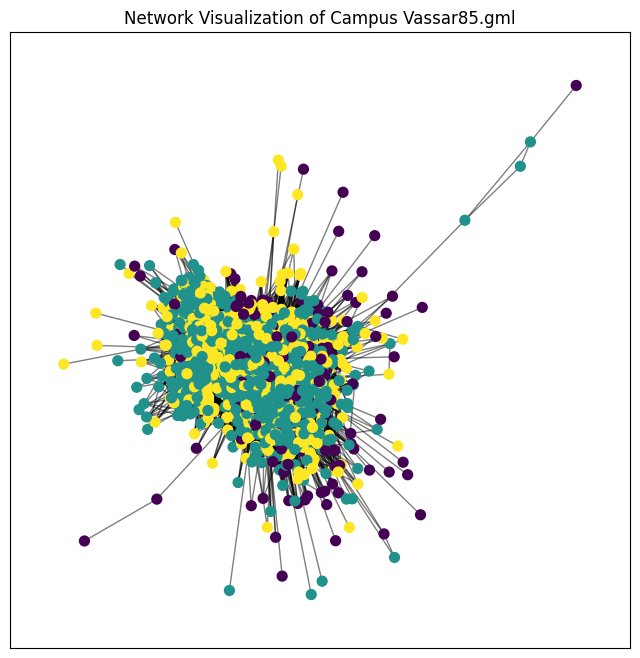

Campus Vassar85.gml, Community 0:
Gender distribution: 7 Unknown, 358 Male, 235 Female
Total members: 600
Proportion of Unknown: 0.01
Proportion of Male: 0.60
Proportion of Female: 0.39

Campus Vassar85.gml, Community 3:
Gender distribution: 130 Unknown, 602 Male, 405 Female
Total members: 1137
Proportion of Unknown: 0.11
Proportion of Male: 0.53
Proportion of Female: 0.36

Campus Vassar85.gml, Community 1:
Gender distribution: 51 Unknown, 350 Male, 203 Female
Total members: 604
Proportion of Unknown: 0.08
Proportion of Male: 0.58
Proportion of Female: 0.34

Campus Vassar85.gml, Community 2:
Gender distribution: 66 Unknown, 266 Male, 200 Female
Total members: 532
Proportion of Unknown: 0.12
Proportion of Male: 0.50
Proportion of Female: 0.38

Campus Vassar85.gml, Community 5:
Gender distribution: 22 Unknown, 114 Male, 55 Female
Total members: 191
Proportion of Unknown: 0.12
Proportion of Male: 0.60
Proportion of Female: 0.29

Campus Vassar85.gml, Community 4:
Gender distribution: 1 Unk

In [157]:
import networkx as nx
import matplotlib.pyplot as plt
import community.community_louvain as cl

total_community = []
for i, G in enumerate(g_all_list):



    pos = nx.spring_layout(G)  # Fruchterman-Reingold算法
    plt.figure(figsize=(8, 8))

    node_colors = [G.nodes[node]['gender'] for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.get_cmap('viridis'), node_size=50)
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    plt.title(f'Network Visualization of Campus {file_names_list[i]}')
    plt.show()


    partition = cl.best_partition(G)


    community_gender = {}
    for node, com_id in partition.items():
        gender = G.nodes[node]['gender']
        community_gender.setdefault(com_id, []).append(gender)

    total_community.append(community_gender)

    for com_id, genders in community_gender.items():
        print(f"Campus {file_names_list[i]}, Community {com_id}:")
        print(f"Gender distribution: {genders.count(0)} Unknown, {genders.count(1)} Male, {genders.count(2)} Female")
        print(f"Total members: {len(genders)}")
        print(f"Proportion of Unknown: {genders.count(0)/len(genders):.2f}")
        print(f"Proportion of Male: {genders.count(1)/len(genders):.2f}")
        print(f"Proportion of Female: {genders.count(2)/len(genders):.2f}\n")


In [155]:
len(total_community)

15

Campus Caltech36.gml
Community 0:
Gender distribution: Unknown=6, Male=42, Female=71
Chi-squared: 53.46, p-value: 0.0000
Significant gender distribution found.



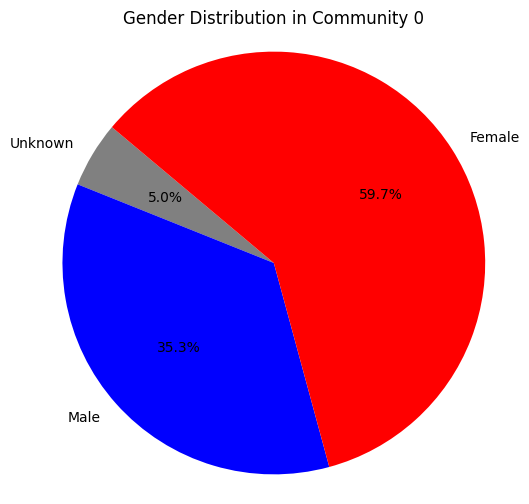

Community 2:
Gender distribution: Unknown=9, Male=22, Female=49
Chi-squared: 31.22, p-value: 0.0000
Significant gender distribution found.



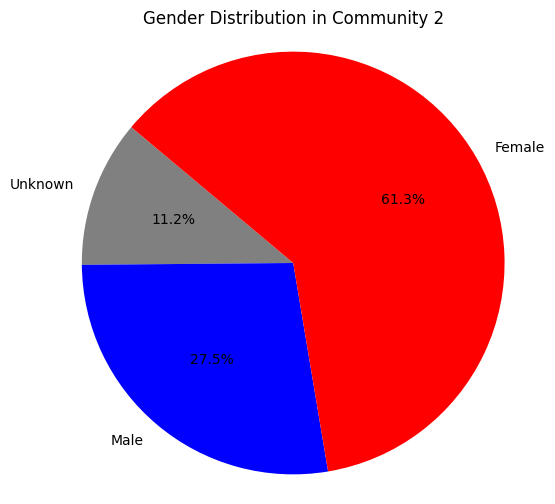

Community 5:
Gender distribution: Unknown=9, Male=47, Female=88
Chi-squared: 65.04, p-value: 0.0000
Significant gender distribution found.



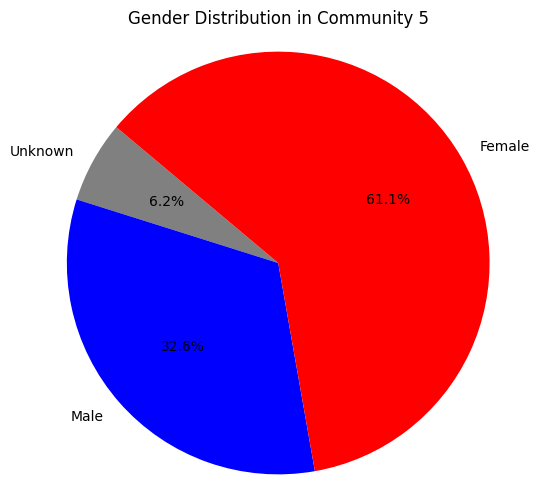

Community 3:
Gender distribution: Unknown=6, Male=22, Female=50
Chi-squared: 38.15, p-value: 0.0000
Significant gender distribution found.



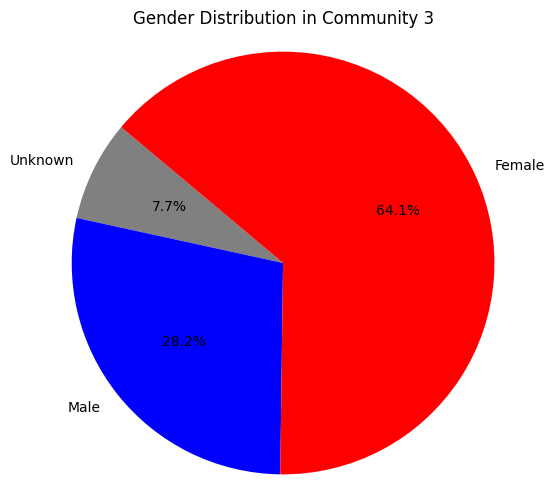

Community 1:
Gender distribution: Unknown=14, Male=22, Female=80
Chi-squared: 67.10, p-value: 0.0000
Significant gender distribution found.



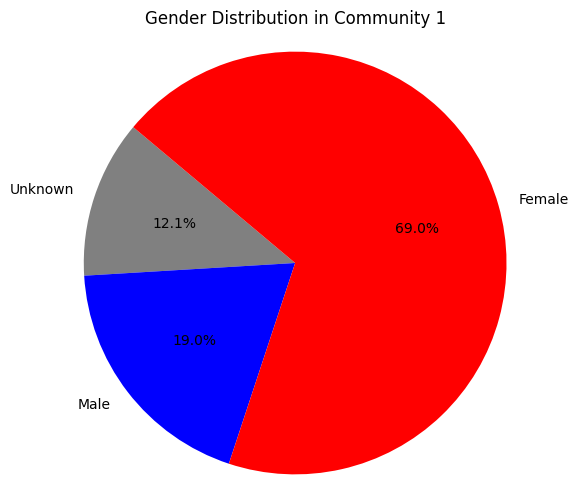

Community 6:
Gender distribution: Unknown=8, Male=39, Female=45
Chi-squared: 25.72, p-value: 0.0000
Significant gender distribution found.



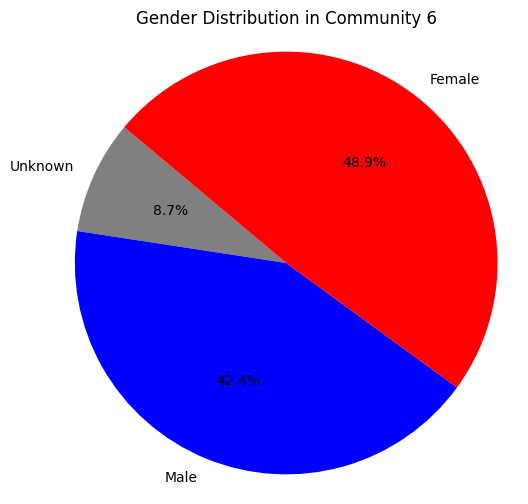

Community 7:
Gender distribution: Unknown=0, Male=5, Female=12
Chi-squared: 12.82, p-value: 0.0016
Significant gender distribution found.



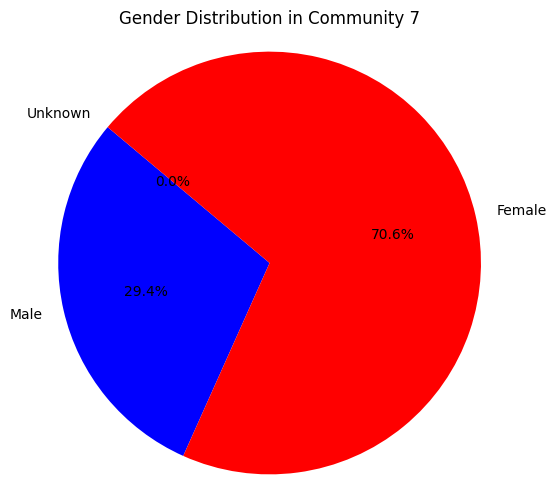

Community 4:
Gender distribution: Unknown=11, Male=28, Female=77
Chi-squared: 60.74, p-value: 0.0000
Significant gender distribution found.



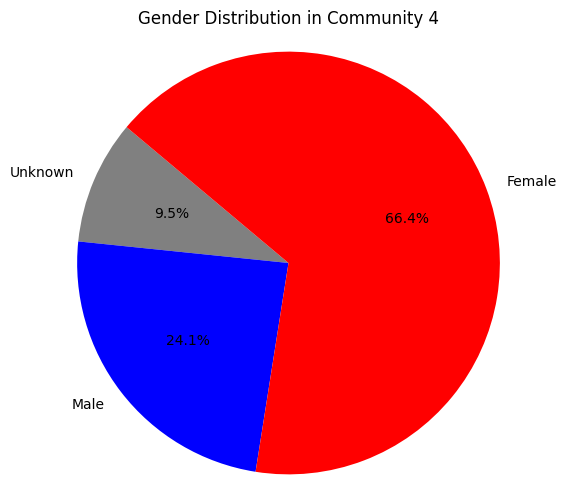

Campus Reed98.gml
Community 4:
Gender distribution: Unknown=23, Male=123, Female=89
Chi-squared: 66.01, p-value: 0.0000
Significant gender distribution found.



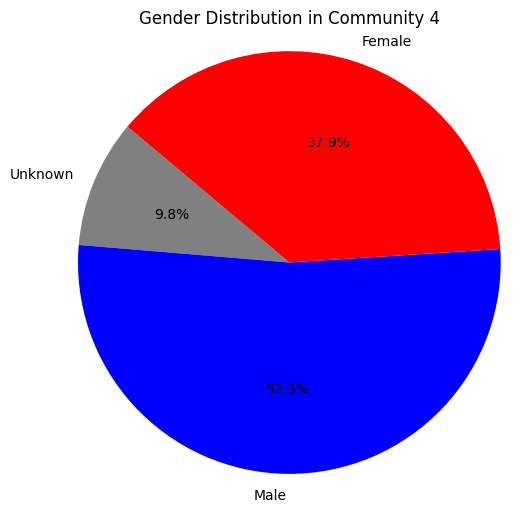

Community 1:
Gender distribution: Unknown=24, Male=105, Female=68
Chi-squared: 50.08, p-value: 0.0000
Significant gender distribution found.



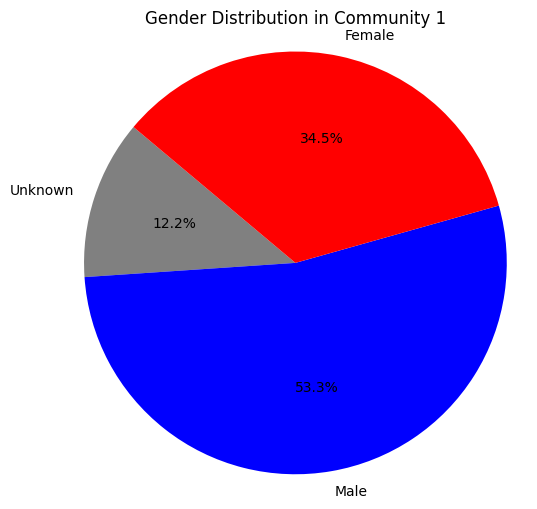

Community 2:
Gender distribution: Unknown=19, Male=53, Female=70
Chi-squared: 28.49, p-value: 0.0000
Significant gender distribution found.



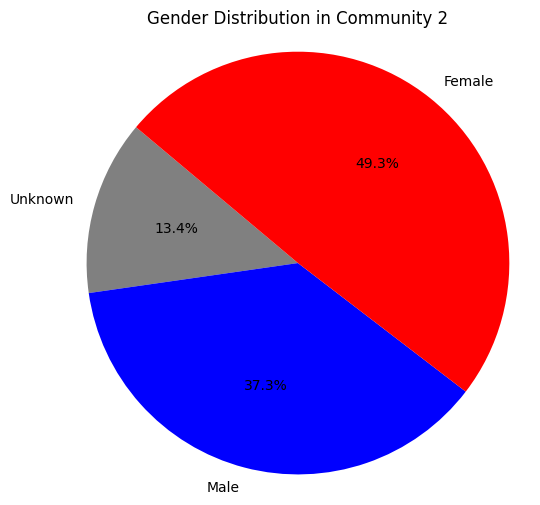

Community 3:
Gender distribution: Unknown=6, Male=114, Female=58
Chi-squared: 98.34, p-value: 0.0000
Significant gender distribution found.



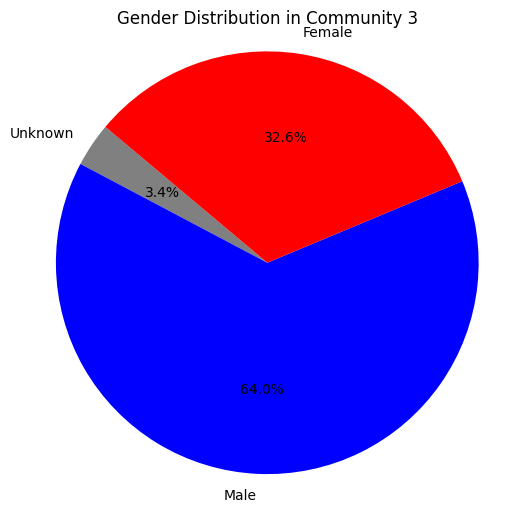

Community 5:
Gender distribution: Unknown=7, Male=33, Female=20
Chi-squared: 16.90, p-value: 0.0002
Significant gender distribution found.



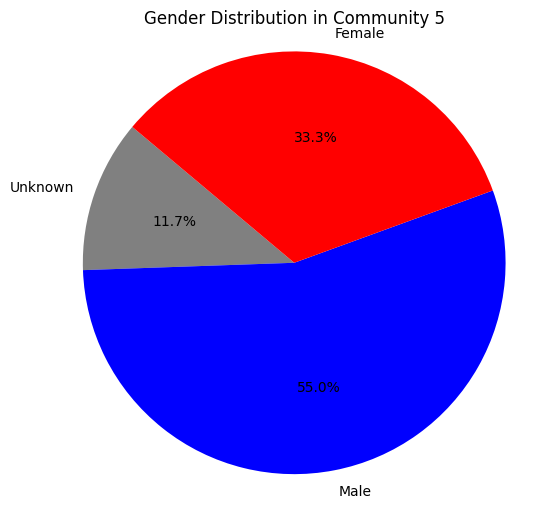

Community 0:
Gender distribution: Unknown=18, Male=76, Female=56
Chi-squared: 34.72, p-value: 0.0000
Significant gender distribution found.



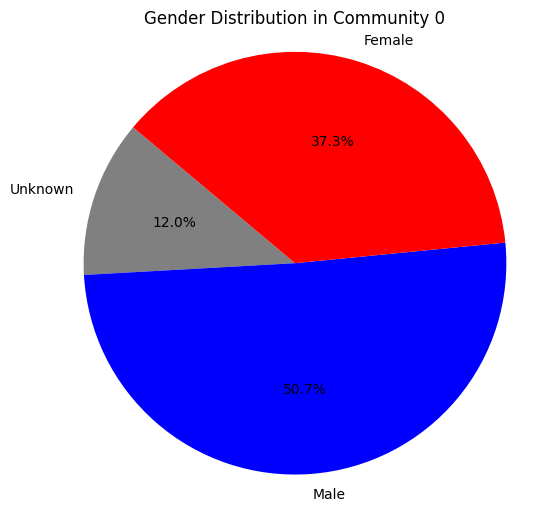

Campus Haverford76.gml
Community 0:
Gender distribution: Unknown=39, Male=197, Female=135
Chi-squared: 102.49, p-value: 0.0000
Significant gender distribution found.



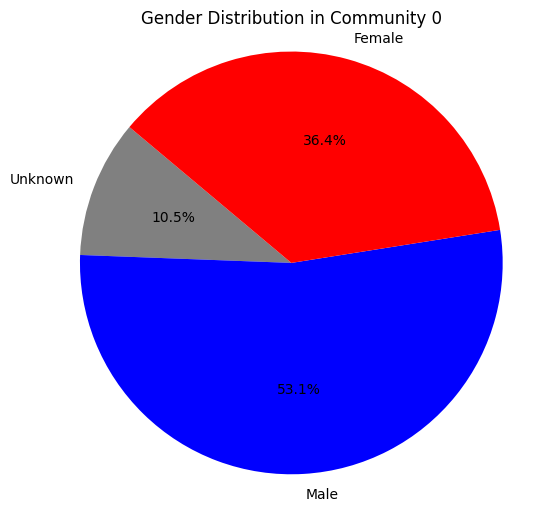

Community 1:
Gender distribution: Unknown=23, Male=175, Female=126
Chi-squared: 111.46, p-value: 0.0000
Significant gender distribution found.



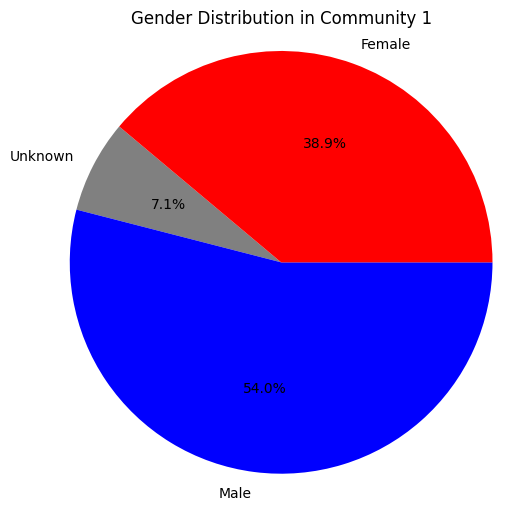

Community 2:
Gender distribution: Unknown=18, Male=135, Female=115
Chi-squared: 87.68, p-value: 0.0000
Significant gender distribution found.



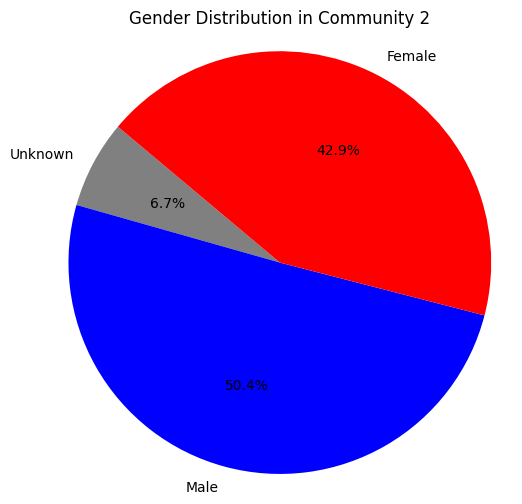

Community 3:
Gender distribution: Unknown=2, Male=159, Female=130
Chi-squared: 143.90, p-value: 0.0000
Significant gender distribution found.



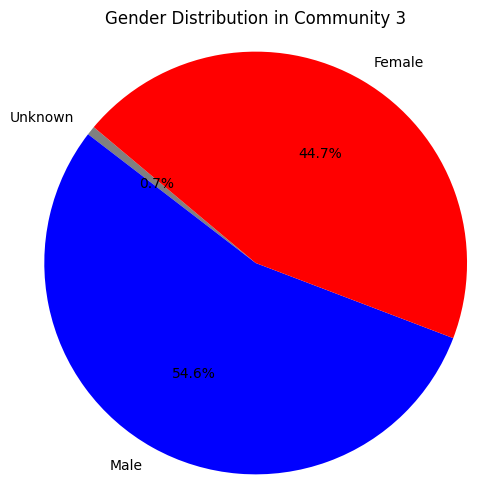

Community 4:
Gender distribution: Unknown=14, Male=66, Female=112
Chi-squared: 75.12, p-value: 0.0000
Significant gender distribution found.



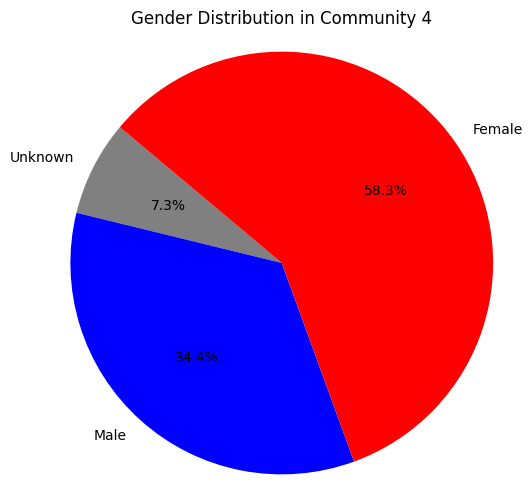

Campus Simmons81.gml
Community 0:
Gender distribution: Unknown=26, Male=319, Female=6
Chi-squared: 524.84, p-value: 0.0000
Significant gender distribution found.



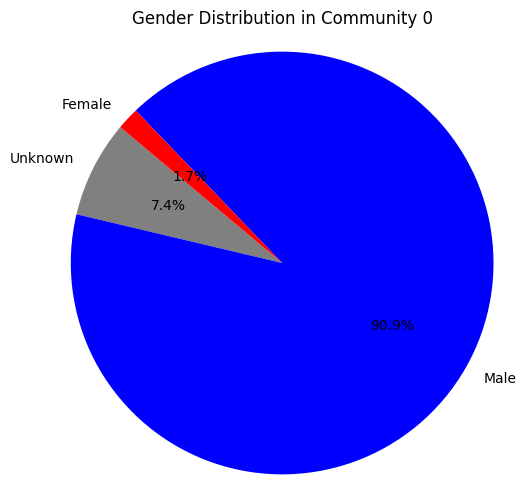

Community 1:
Gender distribution: Unknown=41, Male=374, Female=4
Chi-squared: 594.65, p-value: 0.0000
Significant gender distribution found.



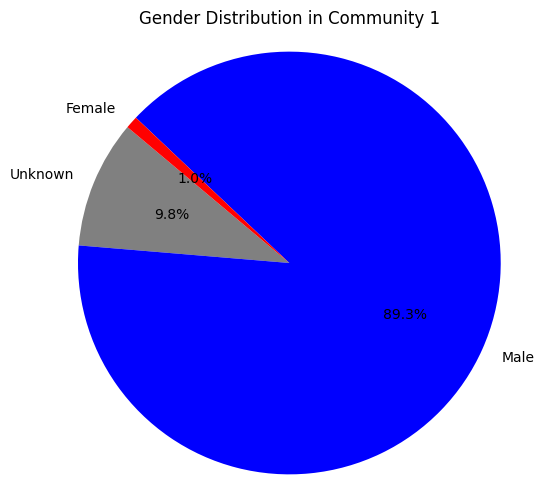

Community 2:
Gender distribution: Unknown=20, Male=363, Female=1
Chi-squared: 648.58, p-value: 0.0000
Significant gender distribution found.



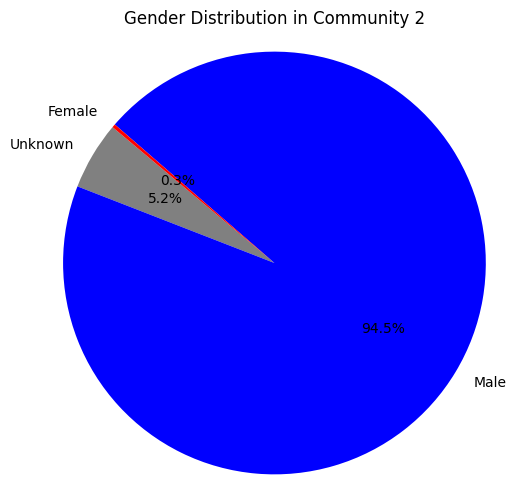

Community 3:
Gender distribution: Unknown=5, Male=307, Female=0
Chi-squared: 594.48, p-value: 0.0000
Significant gender distribution found.



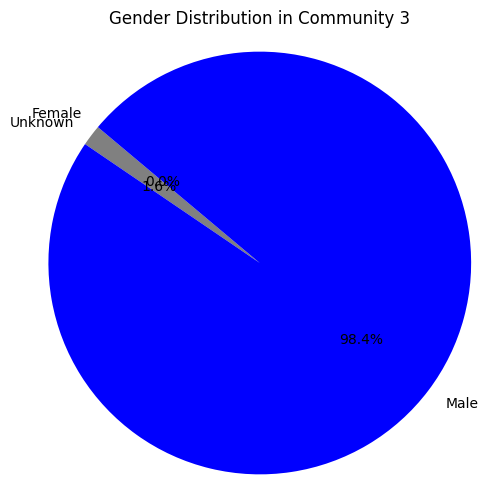

Community 5:
Gender distribution: Unknown=2, Male=11, Female=3
Chi-squared: 9.12, p-value: 0.0104
Significant gender distribution found.



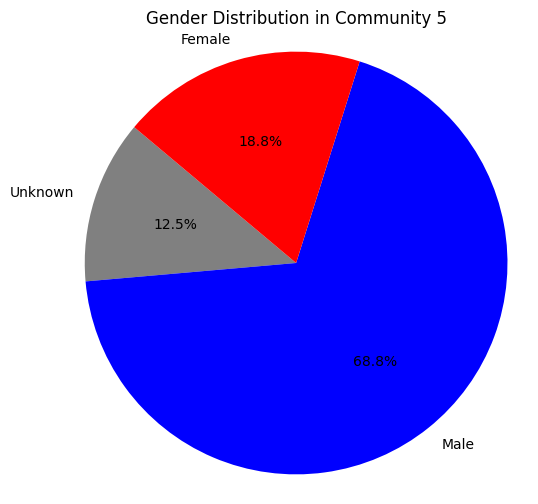

Community 6:
Gender distribution: Unknown=1, Male=22, Female=0
Chi-squared: 40.26, p-value: 0.0000
Significant gender distribution found.



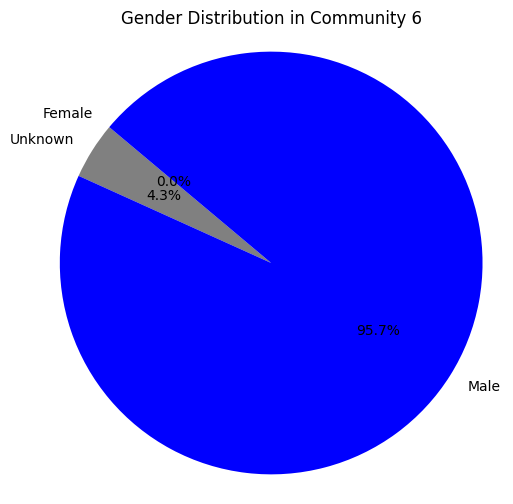

Community 4:
Gender distribution: Unknown=0, Male=5, Female=0
Chi-squared: 10.00, p-value: 0.0067
Significant gender distribution found.



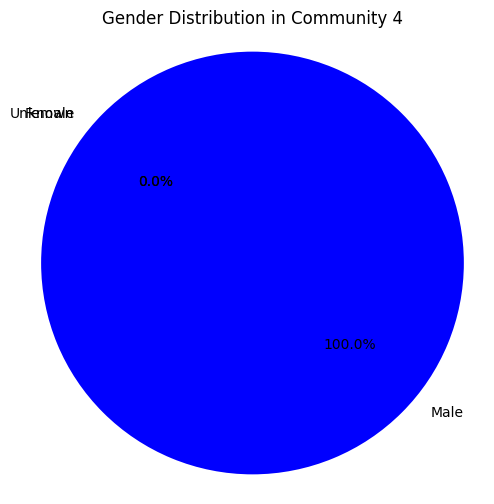

Campus Swarthmore42.gml
Community 0:
Gender distribution: Unknown=28, Male=108, Female=94
Chi-squared: 47.62, p-value: 0.0000
Significant gender distribution found.



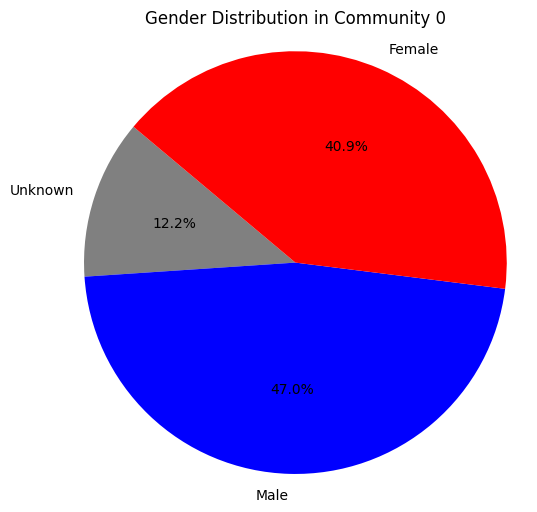

Community 1:
Gender distribution: Unknown=20, Male=136, Female=137
Chi-squared: 92.65, p-value: 0.0000
Significant gender distribution found.



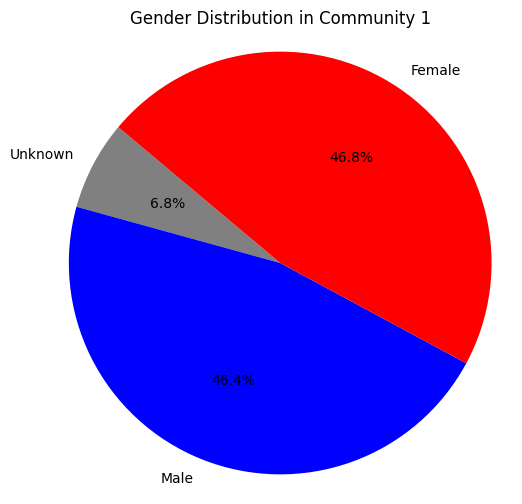

Community 2:
Gender distribution: Unknown=33, Male=108, Female=168
Chi-squared: 88.83, p-value: 0.0000
Significant gender distribution found.



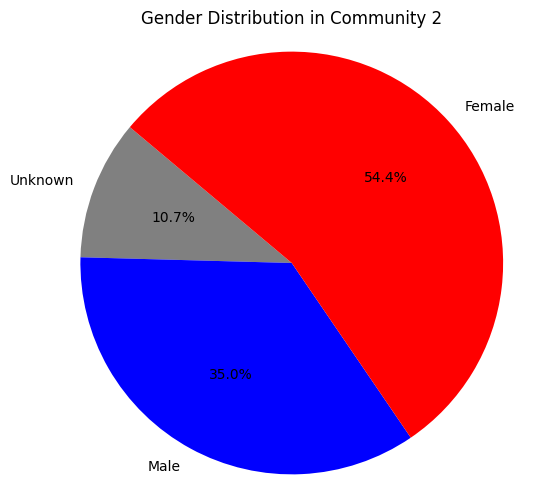

Community 3:
Gender distribution: Unknown=3, Male=162, Female=137
Chi-squared: 145.24, p-value: 0.0000
Significant gender distribution found.



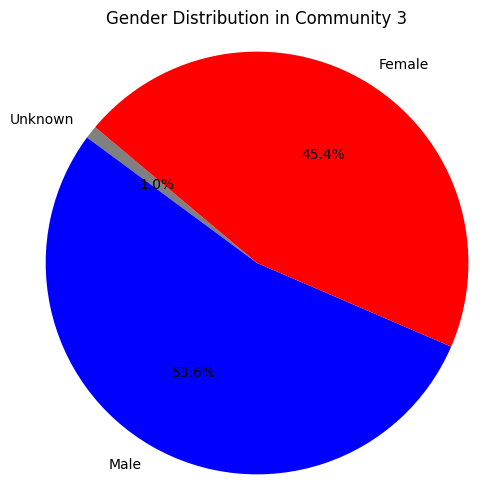

Community 4:
Gender distribution: Unknown=16, Male=72, Female=84
Chi-squared: 45.95, p-value: 0.0000
Significant gender distribution found.



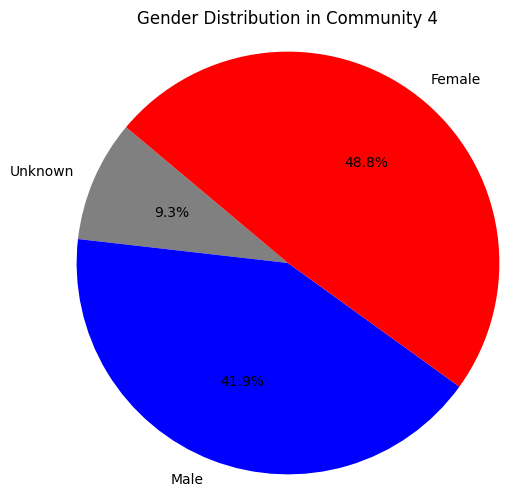

Community 5:
Gender distribution: Unknown=25, Male=116, Female=82
Chi-squared: 56.89, p-value: 0.0000
Significant gender distribution found.



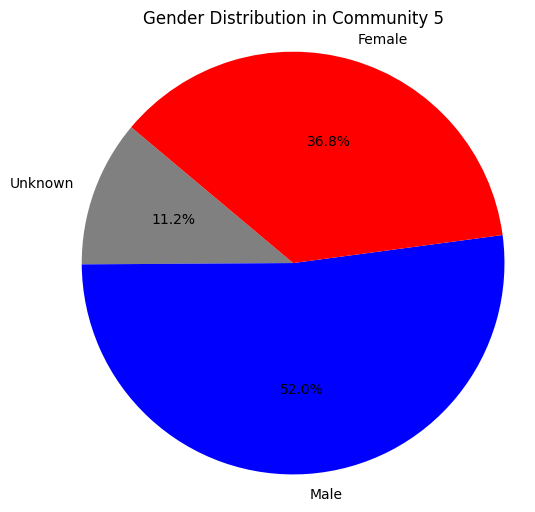

Community 6:
Gender distribution: Unknown=13, Male=69, Female=46
Chi-squared: 37.14, p-value: 0.0000
Significant gender distribution found.



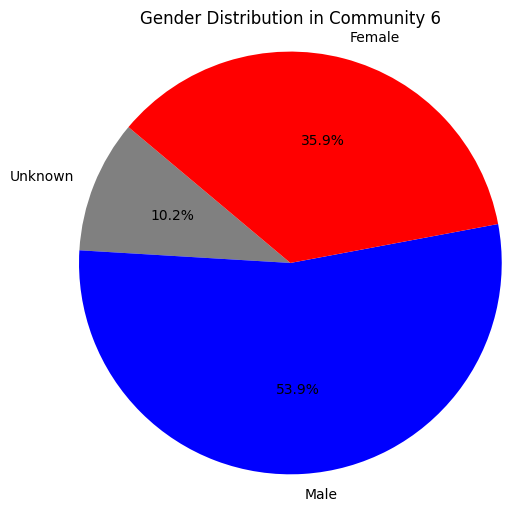

Campus Amherst41.gml
Community 0:
Gender distribution: Unknown=27, Male=177, Female=183
Chi-squared: 121.12, p-value: 0.0000
Significant gender distribution found.



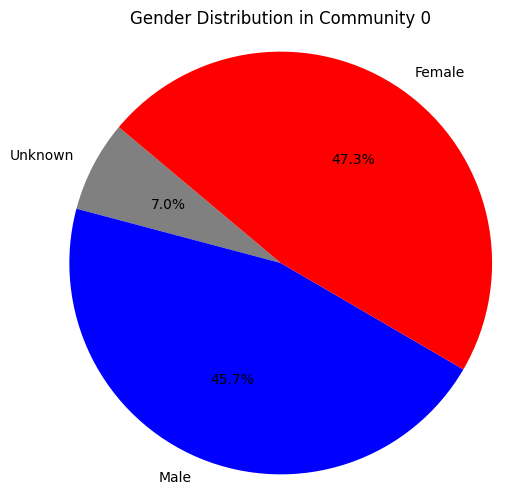

Community 1:
Gender distribution: Unknown=18, Male=104, Female=112
Chi-squared: 69.64, p-value: 0.0000
Significant gender distribution found.



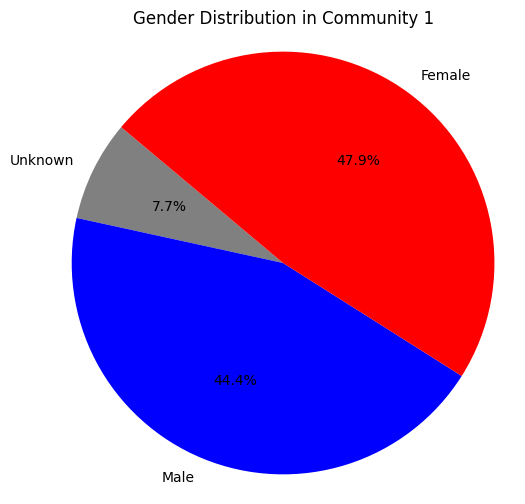

Community 2:
Gender distribution: Unknown=46, Male=152, Female=206
Chi-squared: 98.40, p-value: 0.0000
Significant gender distribution found.



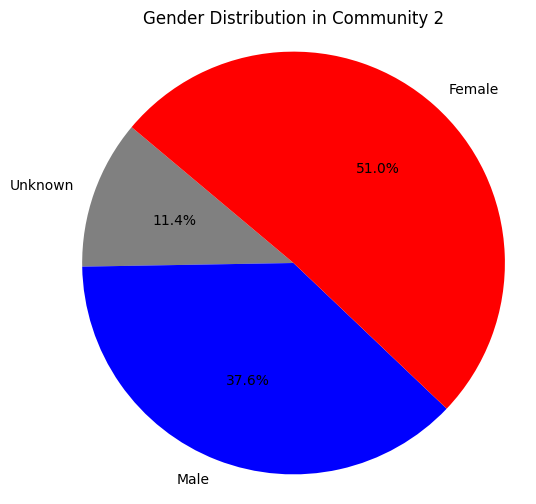

Community 3:
Gender distribution: Unknown=7, Male=195, Female=184
Chi-squared: 173.04, p-value: 0.0000
Significant gender distribution found.



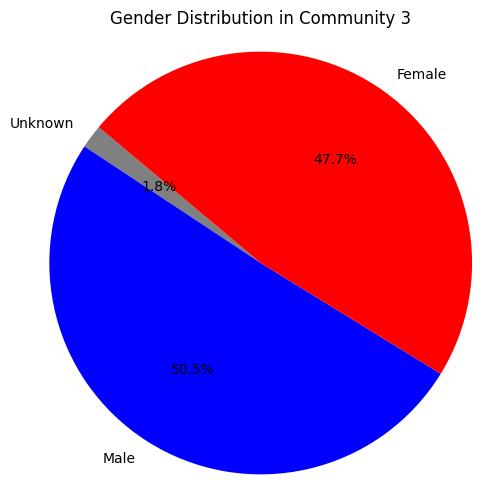

Community 6:
Gender distribution: Unknown=86, Male=293, Female=258
Chi-squared: 115.63, p-value: 0.0000
Significant gender distribution found.



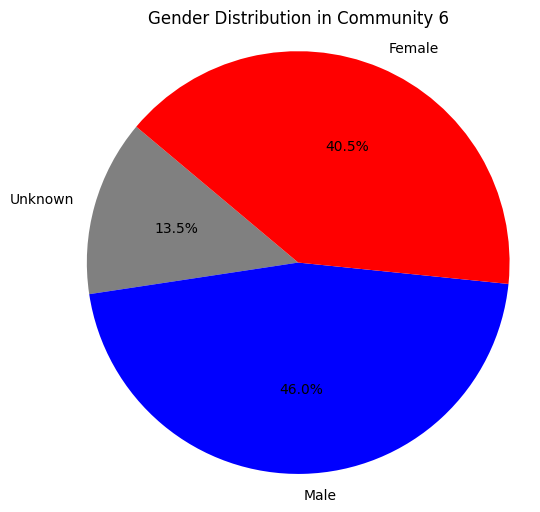

Community 4:
Gender distribution: Unknown=19, Male=92, Female=72
Chi-squared: 46.66, p-value: 0.0000
Significant gender distribution found.



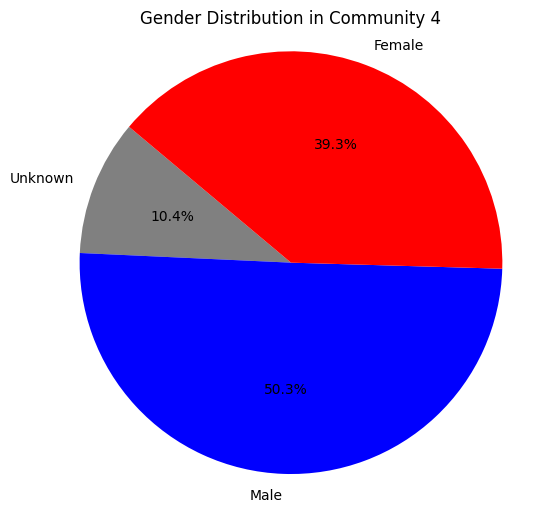

Community 5:
Gender distribution: Unknown=0, Male=2, Female=2
Chi-squared: 2.00, p-value: 0.3679
No significant gender distribution found.



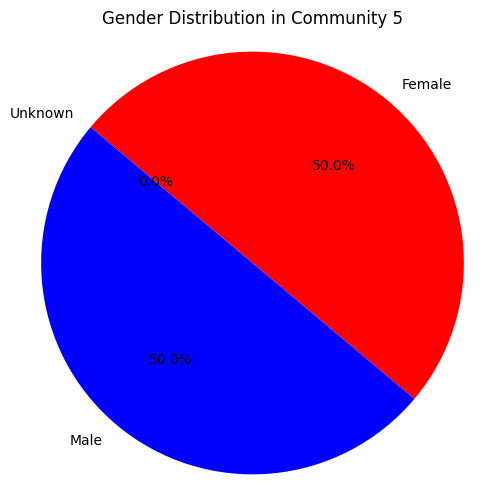

Campus Bowdoin47.gml
Community 0:
Gender distribution: Unknown=70, Male=257, Female=245
Chi-squared: 114.93, p-value: 0.0000
Significant gender distribution found.



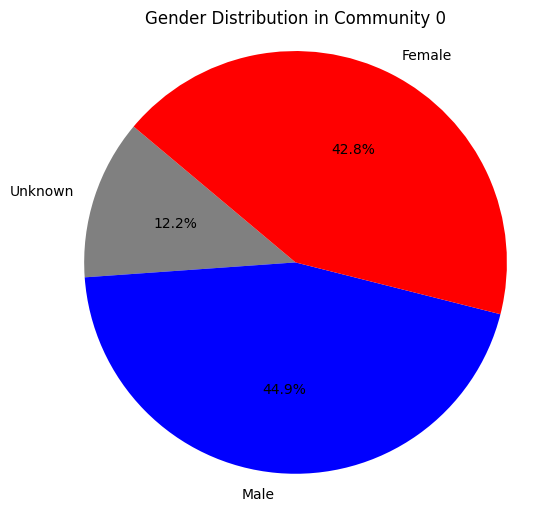

Community 1:
Gender distribution: Unknown=8, Male=230, Female=185
Chi-squared: 195.36, p-value: 0.0000
Significant gender distribution found.



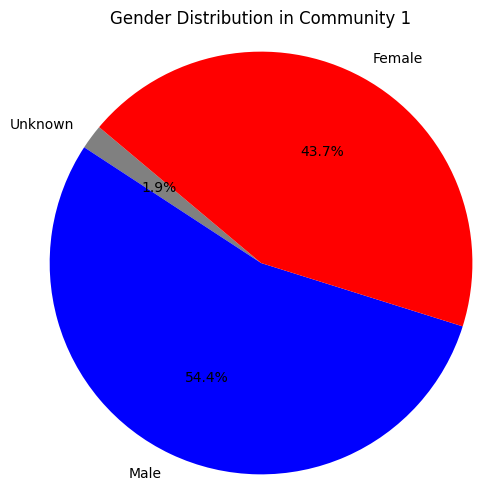

Community 2:
Gender distribution: Unknown=35, Male=197, Female=205
Chi-squared: 126.33, p-value: 0.0000
Significant gender distribution found.



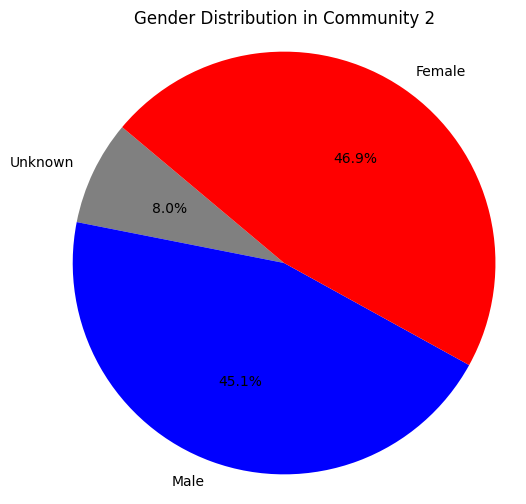

Community 3:
Gender distribution: Unknown=26, Male=145, Female=122
Chi-squared: 81.59, p-value: 0.0000
Significant gender distribution found.



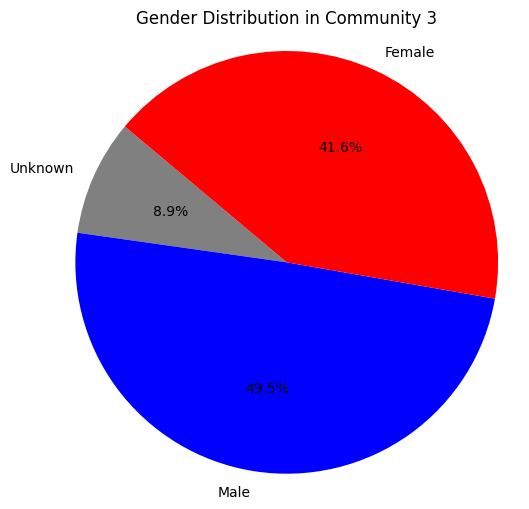

Community 4:
Gender distribution: Unknown=11, Male=49, Female=43
Chi-squared: 24.31, p-value: 0.0000
Significant gender distribution found.



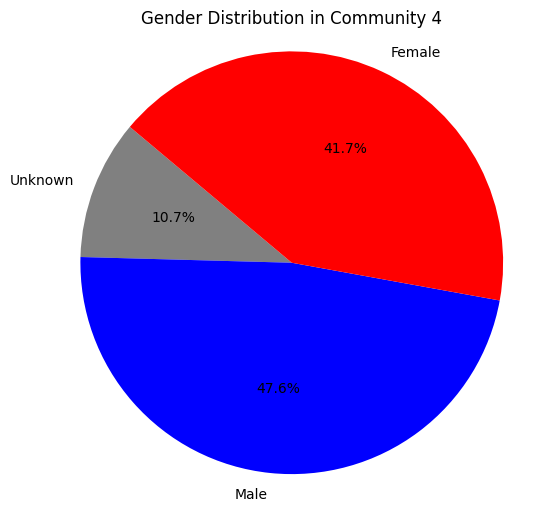

Community 5:
Gender distribution: Unknown=48, Male=171, Female=203
Chi-squared: 95.21, p-value: 0.0000
Significant gender distribution found.



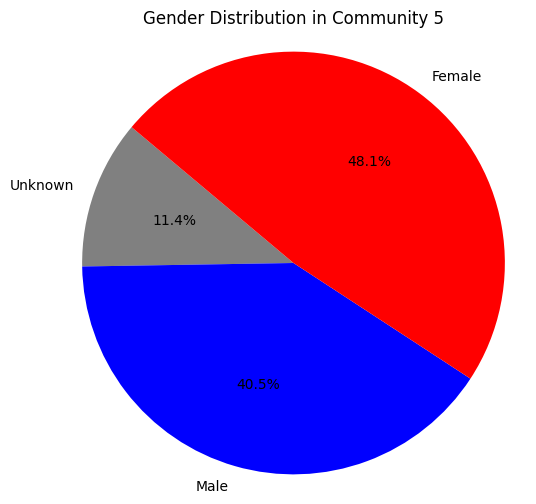

Campus Hamilton46.gml
Community 0:
Gender distribution: Unknown=4, Male=238, Female=213
Chi-squared: 217.72, p-value: 0.0000
Significant gender distribution found.



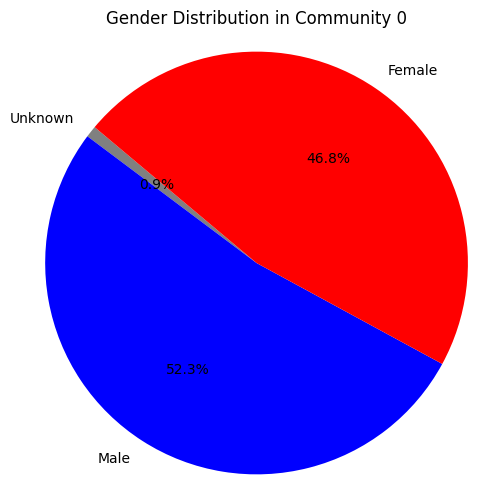

Community 3:
Gender distribution: Unknown=90, Male=367, Female=341
Chi-squared: 175.95, p-value: 0.0000
Significant gender distribution found.



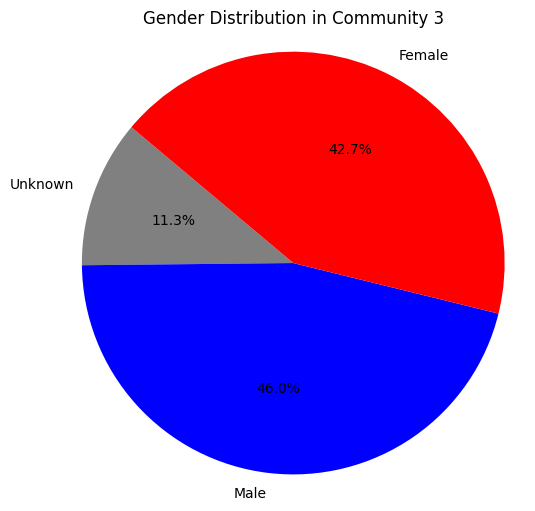

Community 2:
Gender distribution: Unknown=42, Male=198, Female=172
Chi-squared: 101.73, p-value: 0.0000
Significant gender distribution found.



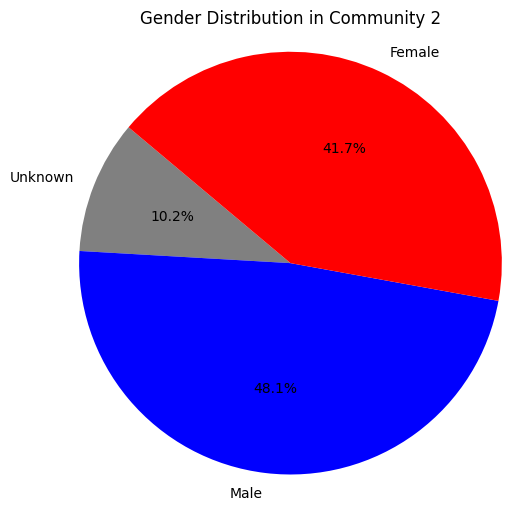

Community 4:
Gender distribution: Unknown=27, Male=210, Female=176
Chi-squared: 137.64, p-value: 0.0000
Significant gender distribution found.



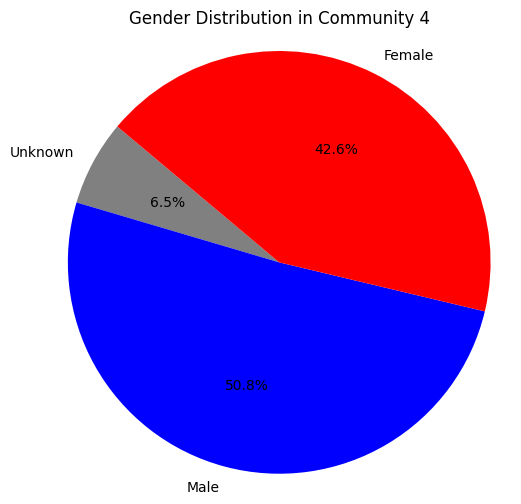

Community 1:
Gender distribution: Unknown=20, Male=118, Female=96
Chi-squared: 67.79, p-value: 0.0000
Significant gender distribution found.



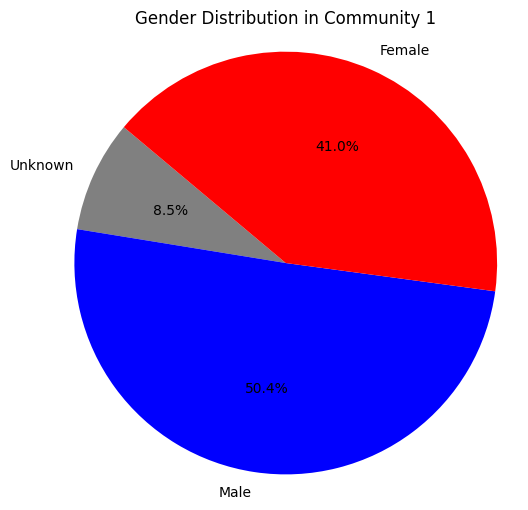

Campus Trinity100.gml
Community 0:
Gender distribution: Unknown=34, Male=231, Female=226
Chi-squared: 154.17, p-value: 0.0000
Significant gender distribution found.



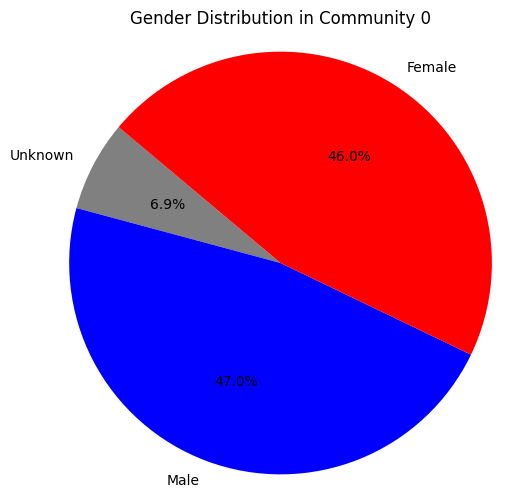

Community 3:
Gender distribution: Unknown=112, Male=307, Female=350
Chi-squared: 125.51, p-value: 0.0000
Significant gender distribution found.



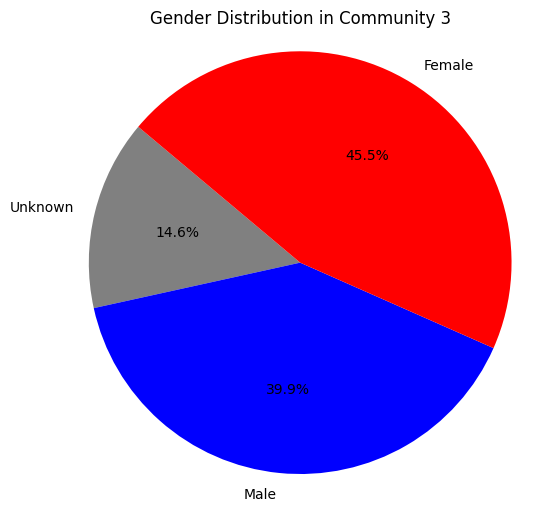

Community 2:
Gender distribution: Unknown=7, Male=253, Female=228
Chi-squared: 225.37, p-value: 0.0000
Significant gender distribution found.



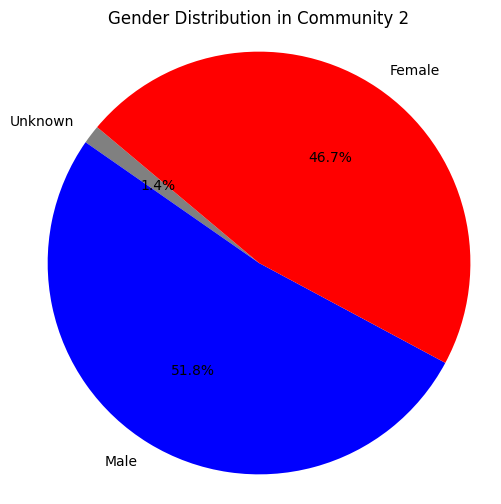

Community 6:
Gender distribution: Unknown=16, Male=93, Female=67
Chi-squared: 52.31, p-value: 0.0000
Significant gender distribution found.



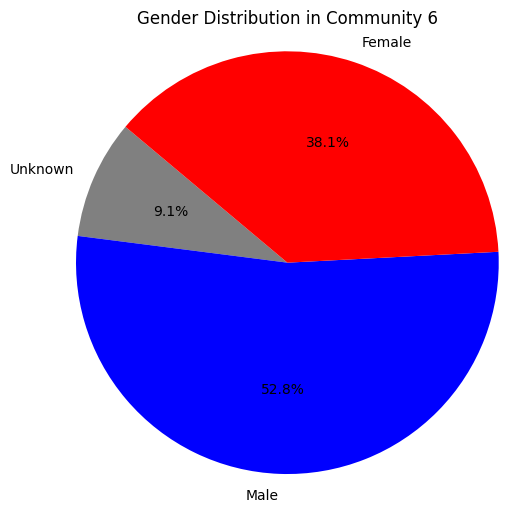

Community 4:
Gender distribution: Unknown=55, Male=272, Female=235
Chi-squared: 143.88, p-value: 0.0000
Significant gender distribution found.



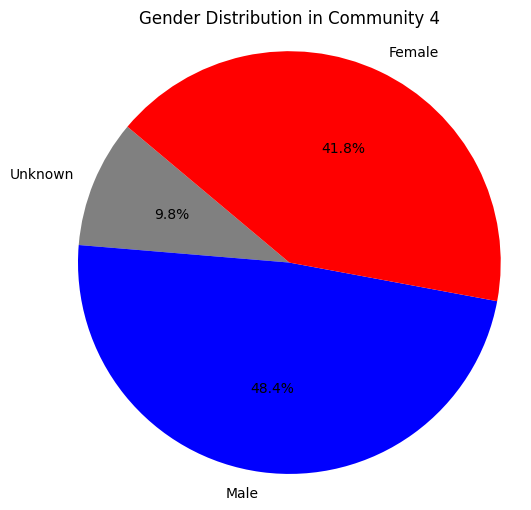

Community 1:
Gender distribution: Unknown=13, Male=68, Female=43
Chi-squared: 36.69, p-value: 0.0000
Significant gender distribution found.



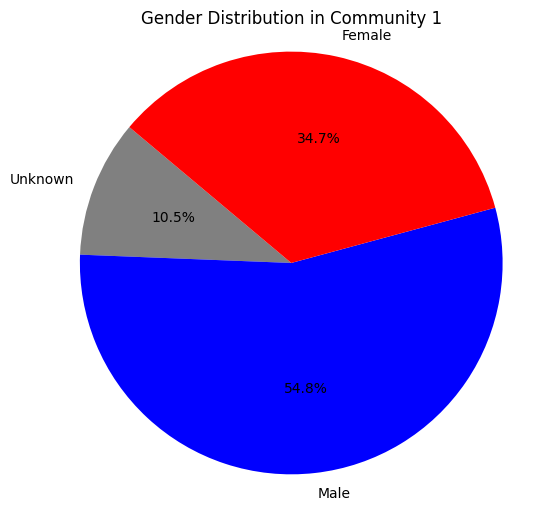

Community 5:
Gender distribution: Unknown=2, Male=1, Female=0
Chi-squared: 2.00, p-value: 0.3679
No significant gender distribution found.



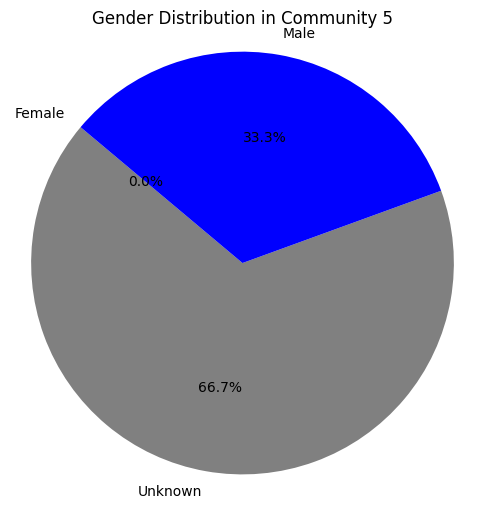

Campus USFCA72.gml
Community 0:
Gender distribution: Unknown=31, Male=285, Female=120
Chi-squared: 228.58, p-value: 0.0000
Significant gender distribution found.



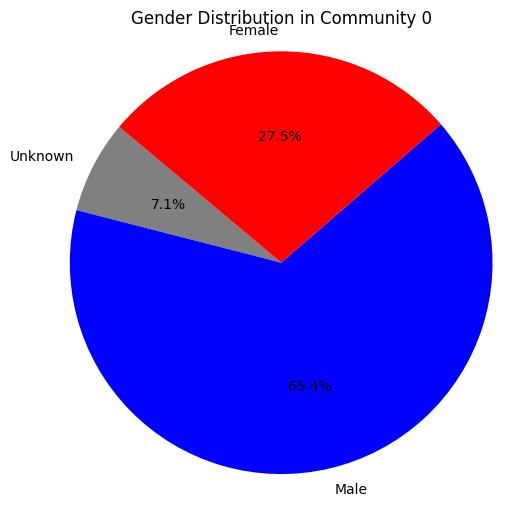

Community 1:
Gender distribution: Unknown=5, Male=406, Female=150
Chi-squared: 440.93, p-value: 0.0000
Significant gender distribution found.



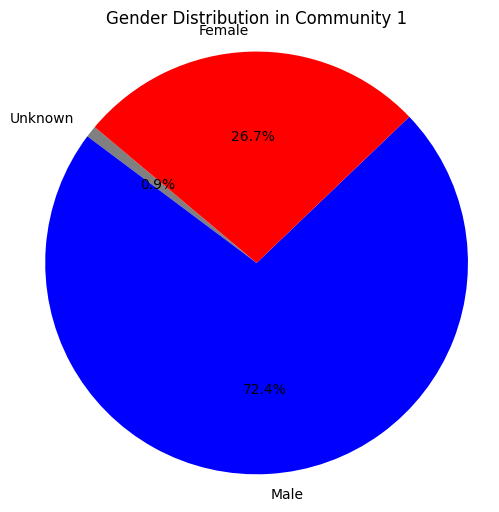

Community 2:
Gender distribution: Unknown=31, Male=205, Female=70
Chi-squared: 163.47, p-value: 0.0000
Significant gender distribution found.



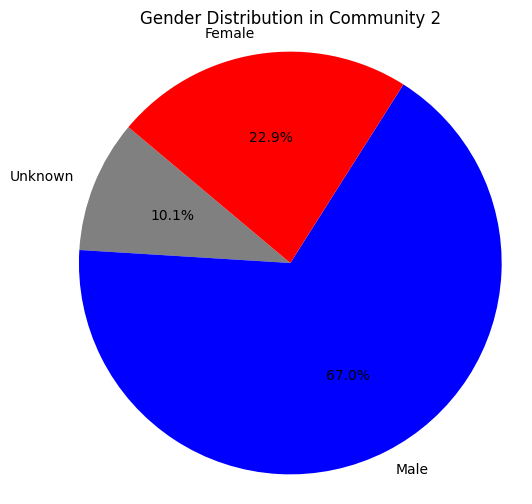

Community 3:
Gender distribution: Unknown=24, Male=307, Female=180
Chi-squared: 235.92, p-value: 0.0000
Significant gender distribution found.



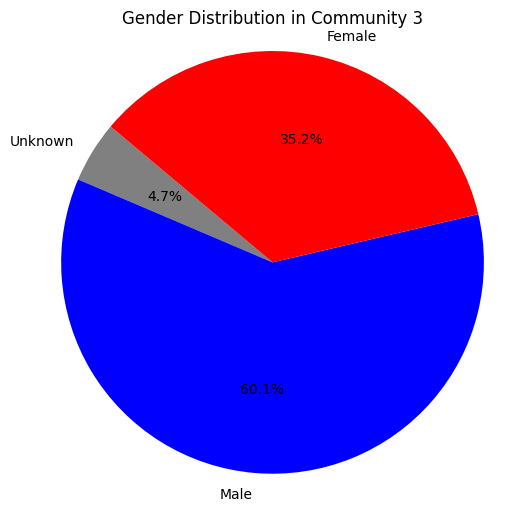

Community 6:
Gender distribution: Unknown=36, Male=188, Female=156
Chi-squared: 101.39, p-value: 0.0000
Significant gender distribution found.



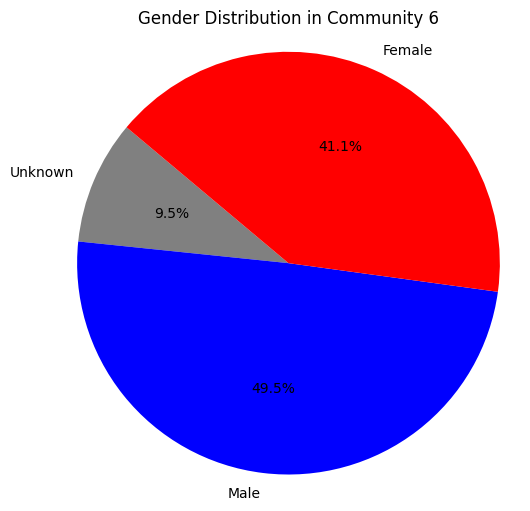

Community 5:
Gender distribution: Unknown=42, Male=296, Female=122
Chi-squared: 219.98, p-value: 0.0000
Significant gender distribution found.



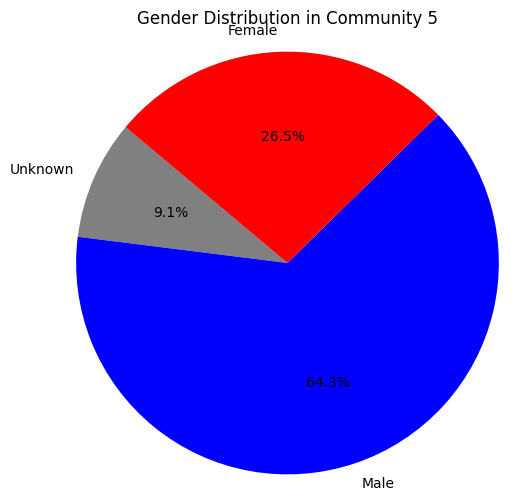

Community 7:
Gender distribution: Unknown=1, Male=8, Female=4
Chi-squared: 5.69, p-value: 0.0581
No significant gender distribution found.



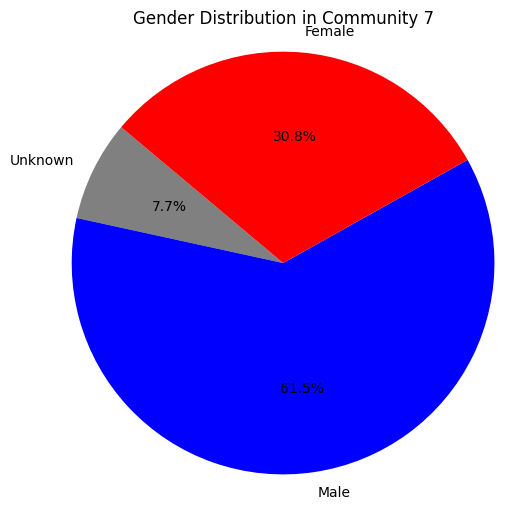

Community 4:
Gender distribution: Unknown=1, Male=2, Female=2
Chi-squared: 0.40, p-value: 0.8187
No significant gender distribution found.



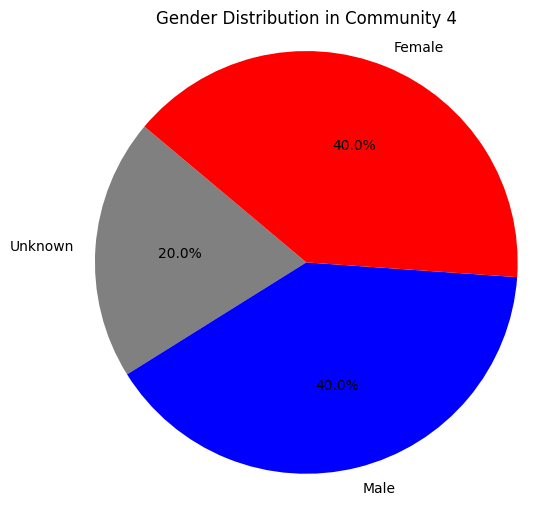

Campus Williams40.gml
Community 0:
Gender distribution: Unknown=56, Male=274, Female=250
Chi-squared: 147.82, p-value: 0.0000
Significant gender distribution found.



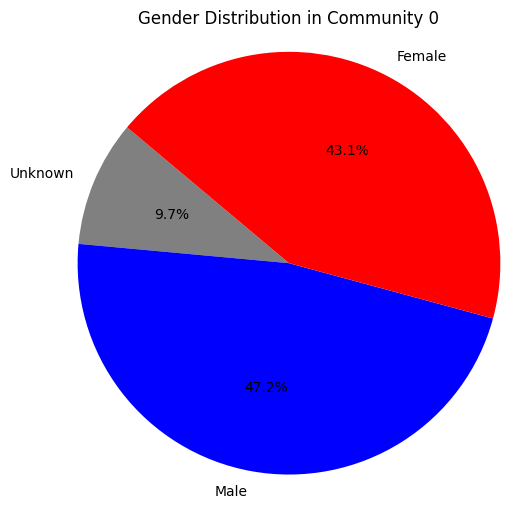

Community 1:
Gender distribution: Unknown=22, Male=159, Female=120
Chi-squared: 99.32, p-value: 0.0000
Significant gender distribution found.



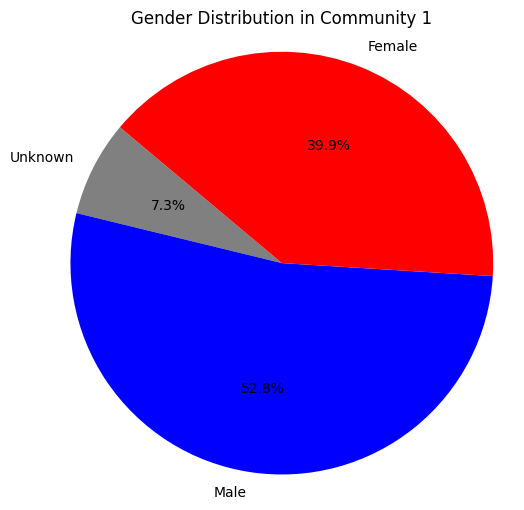

Community 2:
Gender distribution: Unknown=60, Male=255, Female=260
Chi-squared: 135.74, p-value: 0.0000
Significant gender distribution found.



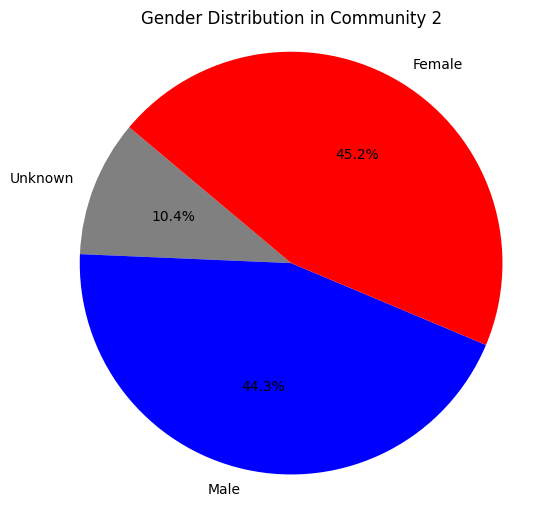

Community 3:
Gender distribution: Unknown=9, Male=243, Female=210
Chi-squared: 208.32, p-value: 0.0000
Significant gender distribution found.



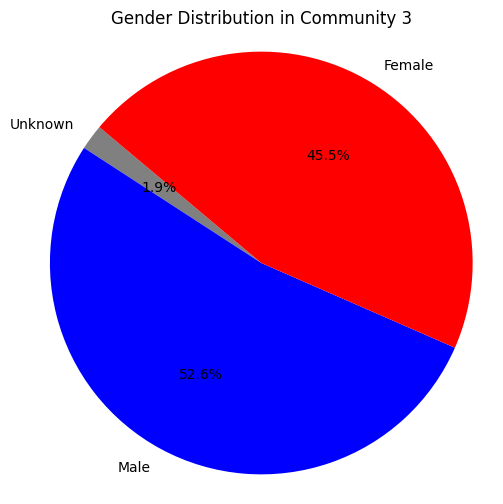

Community 4:
Gender distribution: Unknown=34, Male=108, Female=123
Chi-squared: 51.40, p-value: 0.0000
Significant gender distribution found.



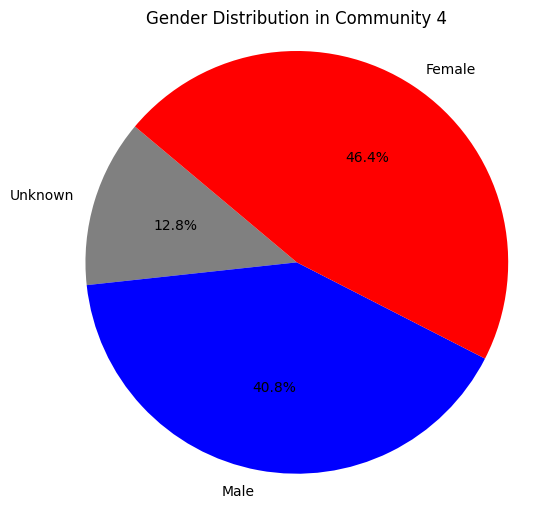

Community 5:
Gender distribution: Unknown=39, Male=118, Female=81
Chi-squared: 39.39, p-value: 0.0000
Significant gender distribution found.



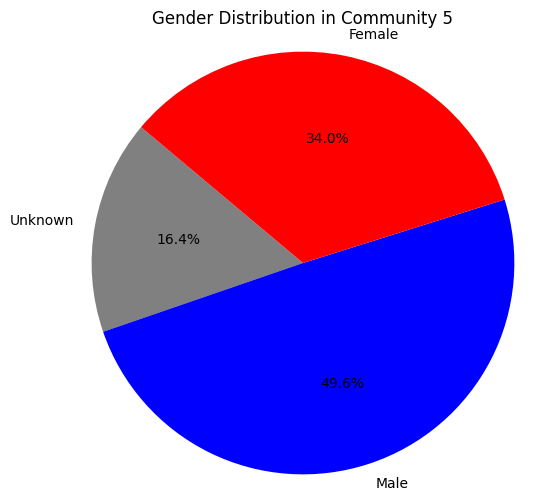

Community 6:
Gender distribution: Unknown=34, Male=166, Female=167
Chi-squared: 95.68, p-value: 0.0000
Significant gender distribution found.



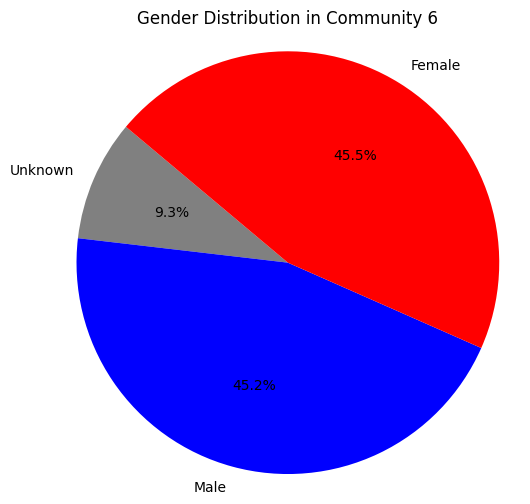

Campus Oberlin44.gml
Community 4:
Gender distribution: Unknown=93, Male=393, Female=277
Chi-squared: 179.96, p-value: 0.0000
Significant gender distribution found.



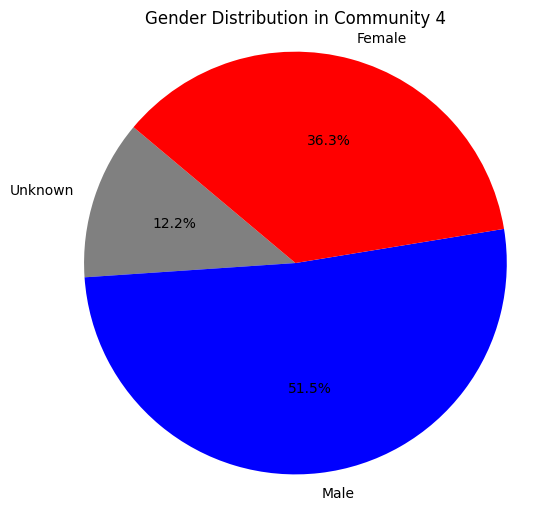

Community 0:
Gender distribution: Unknown=33, Male=201, Female=205
Chi-squared: 131.72, p-value: 0.0000
Significant gender distribution found.



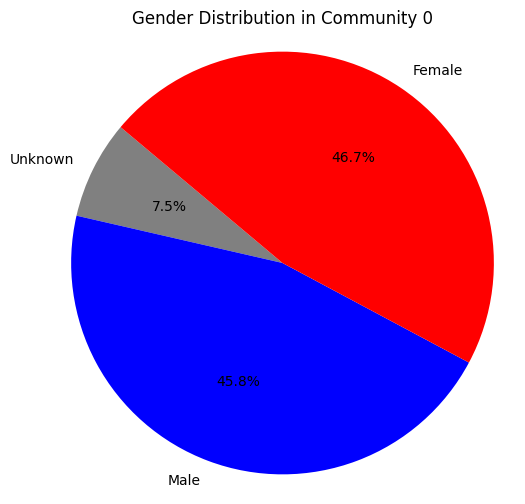

Community 2:
Gender distribution: Unknown=59, Male=229, Female=201
Chi-squared: 101.94, p-value: 0.0000
Significant gender distribution found.



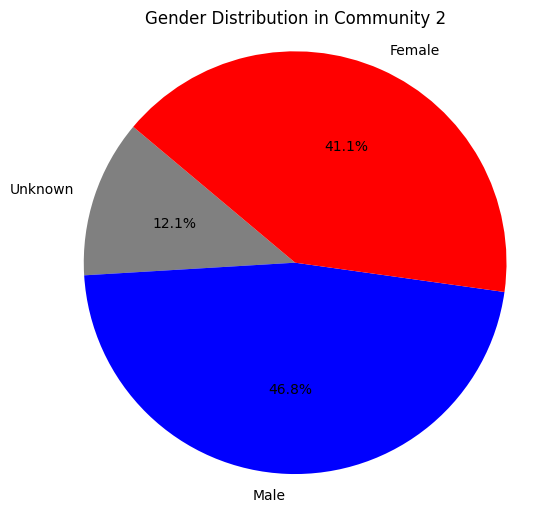

Community 1:
Gender distribution: Unknown=32, Male=233, Female=168
Chi-squared: 145.78, p-value: 0.0000
Significant gender distribution found.



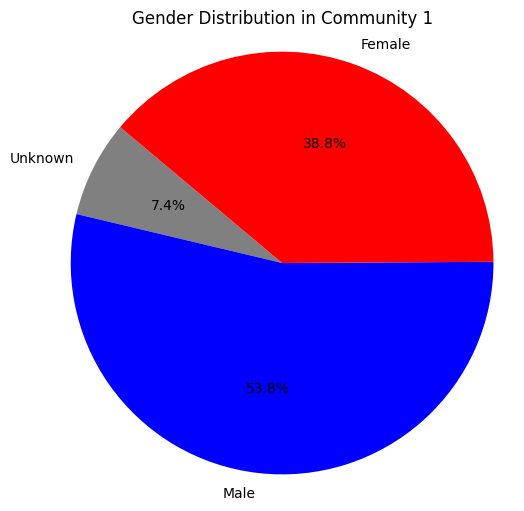

Community 5:
Gender distribution: Unknown=11, Male=249, Female=161
Chi-squared: 206.38, p-value: 0.0000
Significant gender distribution found.



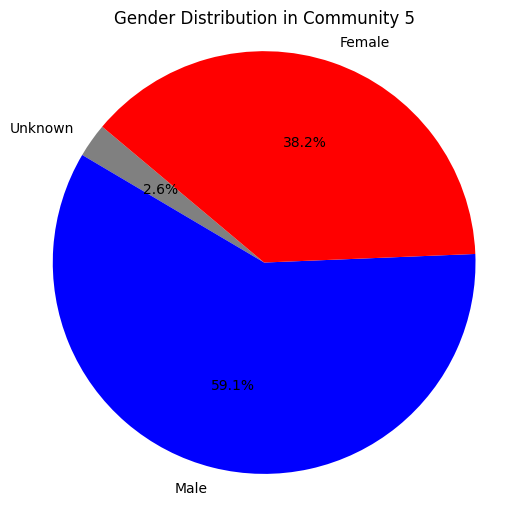

Community 3:
Gender distribution: Unknown=44, Male=183, Female=148
Chi-squared: 83.63, p-value: 0.0000
Significant gender distribution found.



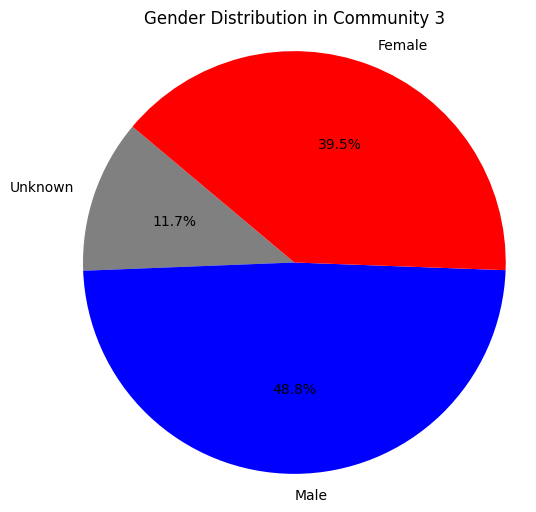

Campus Wellesley22.gml
Community 0:
Gender distribution: Unknown=47, Male=583, Female=5
Chi-squared: 981.33, p-value: 0.0000
Significant gender distribution found.



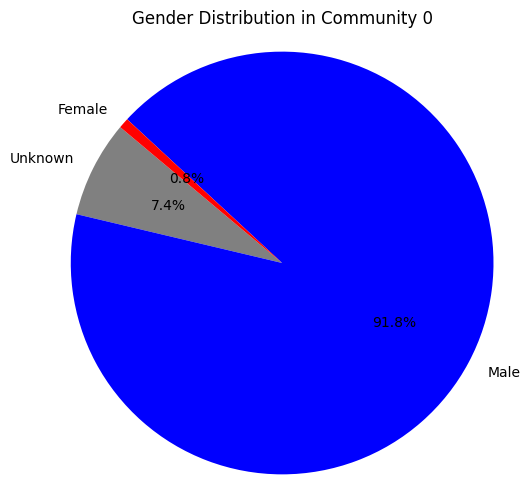

Community 1:
Gender distribution: Unknown=76, Male=435, Female=3
Chi-squared: 624.19, p-value: 0.0000
Significant gender distribution found.



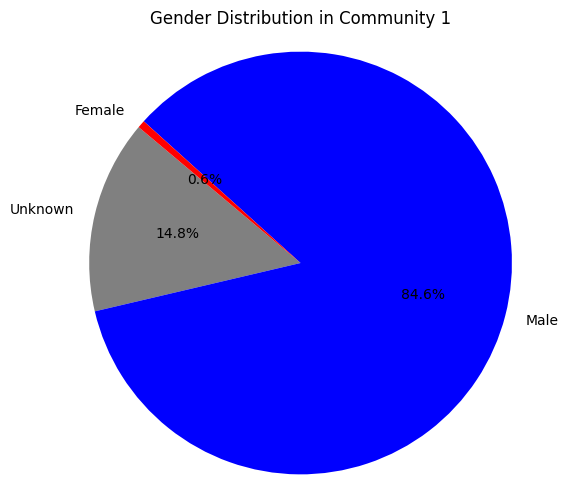

Community 2:
Gender distribution: Unknown=53, Male=501, Female=1
Chi-squared: 816.95, p-value: 0.0000
Significant gender distribution found.



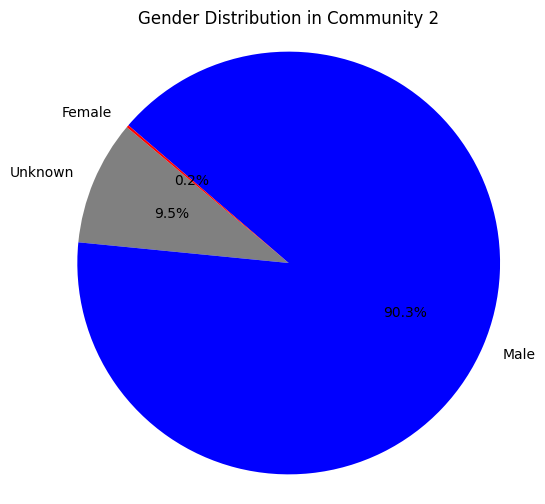

Community 3:
Gender distribution: Unknown=70, Male=465, Female=2
Chi-squared: 698.36, p-value: 0.0000
Significant gender distribution found.



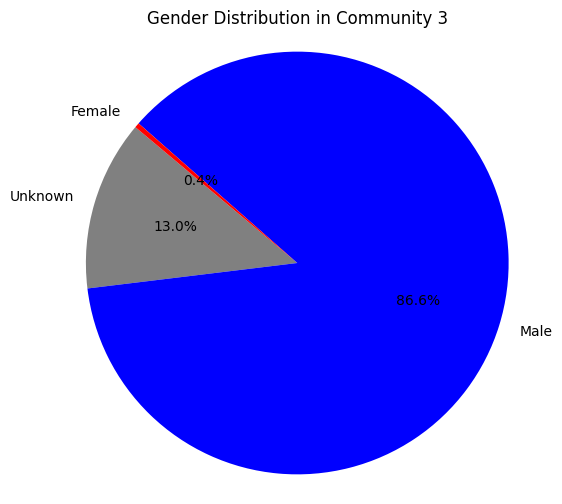

Community 4:
Gender distribution: Unknown=11, Male=166, Female=0
Chi-squared: 292.10, p-value: 0.0000
Significant gender distribution found.



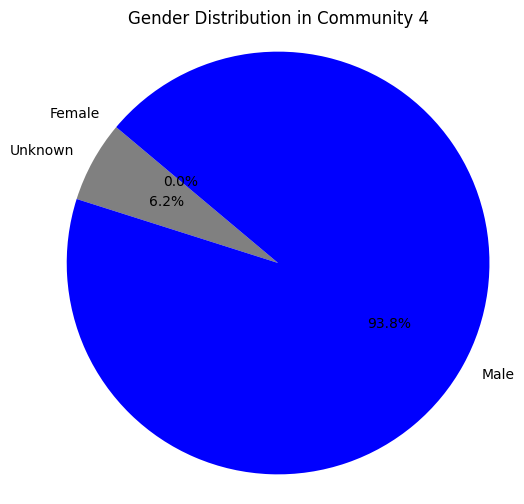

Community 5:
Gender distribution: Unknown=18, Male=492, Female=3
Chi-squared: 904.53, p-value: 0.0000
Significant gender distribution found.



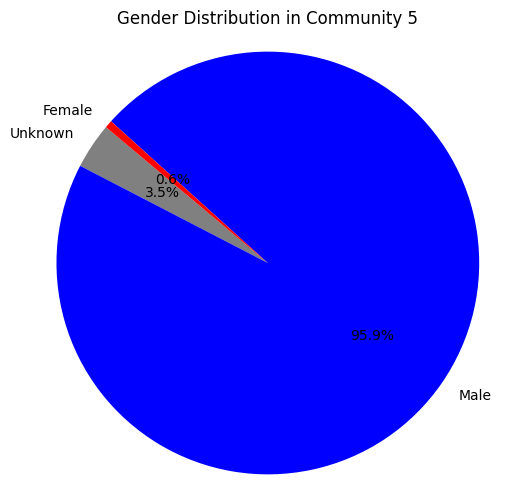

Community 6:
Gender distribution: Unknown=2, Male=15, Female=22
Chi-squared: 15.85, p-value: 0.0004
Significant gender distribution found.



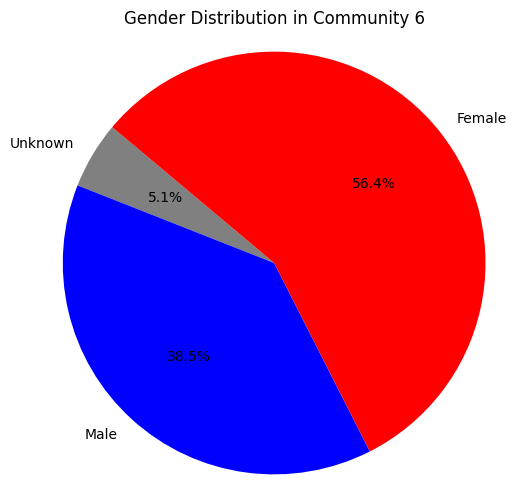

Campus Smith60.gml
Community 17:
Gender distribution: Unknown=59, Male=234, Female=6
Chi-squared: 285.68, p-value: 0.0000
Significant gender distribution found.



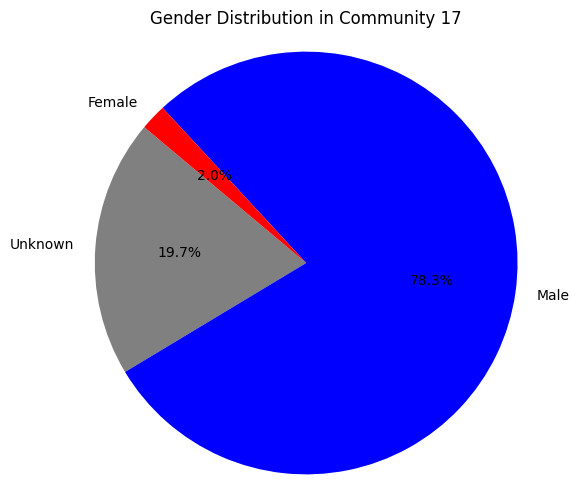

Community 1:
Gender distribution: Unknown=24, Male=152, Female=4
Chi-squared: 214.93, p-value: 0.0000
Significant gender distribution found.



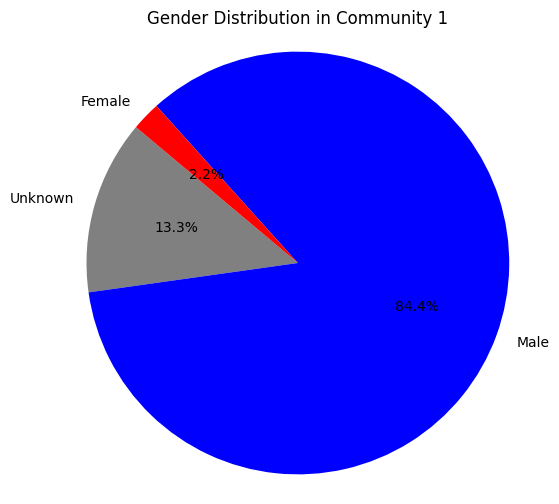

Community 3:
Gender distribution: Unknown=61, Male=416, Female=1
Chi-squared: 631.49, p-value: 0.0000
Significant gender distribution found.



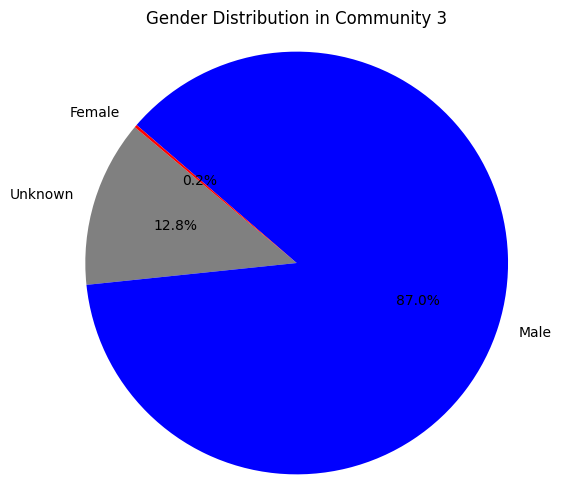

Community 14:
Gender distribution: Unknown=11, Male=78, Female=0
Chi-squared: 120.16, p-value: 0.0000
Significant gender distribution found.



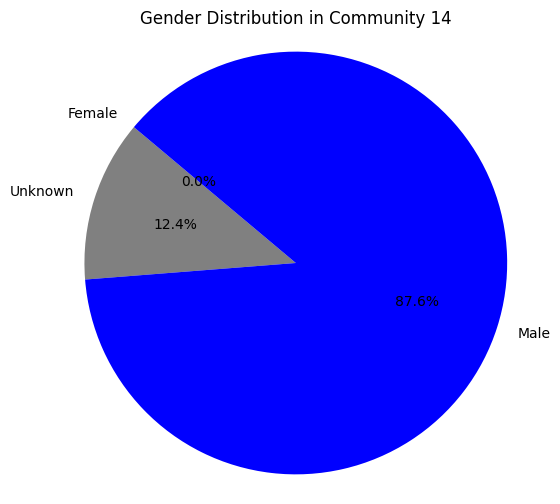

Community 5:
Gender distribution: Unknown=5, Male=75, Female=3
Chi-squared: 121.54, p-value: 0.0000
Significant gender distribution found.



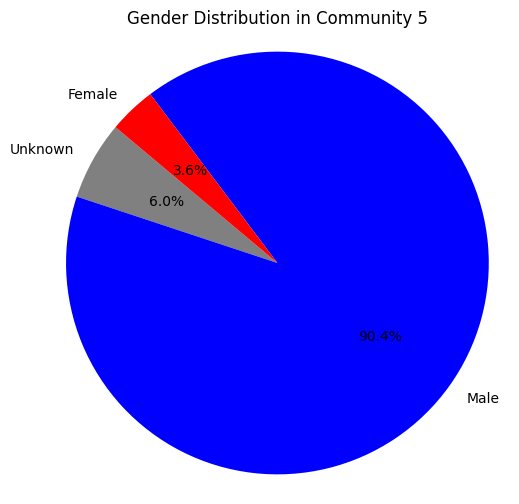

Community 4:
Gender distribution: Unknown=12, Male=385, Female=1
Chi-squared: 720.37, p-value: 0.0000
Significant gender distribution found.



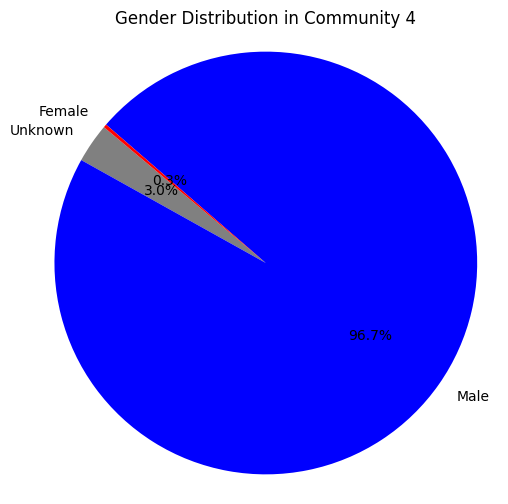

Community 7:
Gender distribution: Unknown=15, Male=170, Female=0
Chi-squared: 287.30, p-value: 0.0000
Significant gender distribution found.



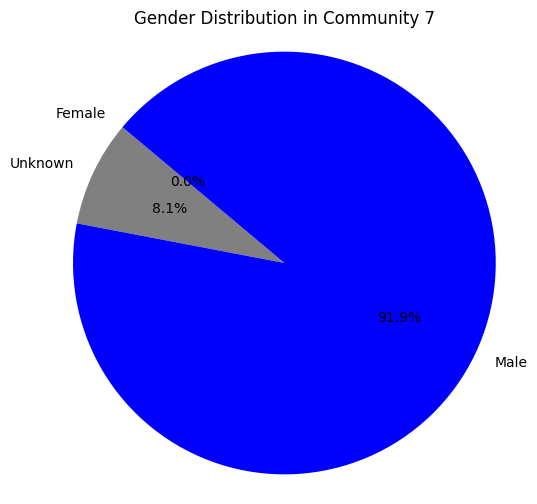

Community 2:
Gender distribution: Unknown=15, Male=80, Female=2
Chi-squared: 108.02, p-value: 0.0000
Significant gender distribution found.



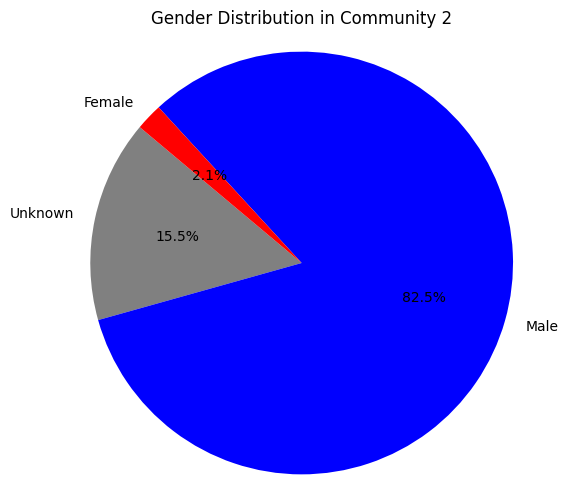

Community 9:
Gender distribution: Unknown=16, Male=97, Female=3
Chi-squared: 134.19, p-value: 0.0000
Significant gender distribution found.



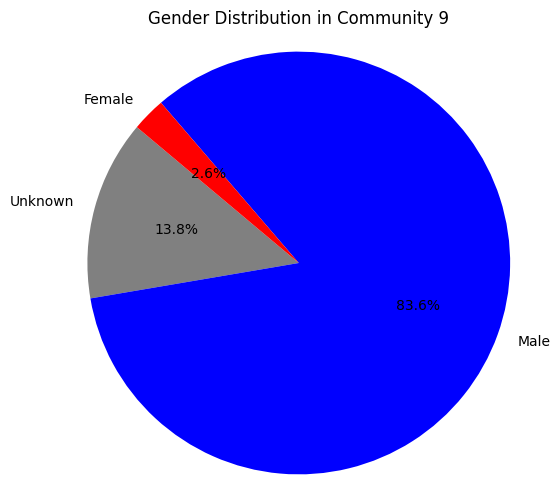

Community 10:
Gender distribution: Unknown=16, Male=191, Female=2
Chi-squared: 318.38, p-value: 0.0000
Significant gender distribution found.



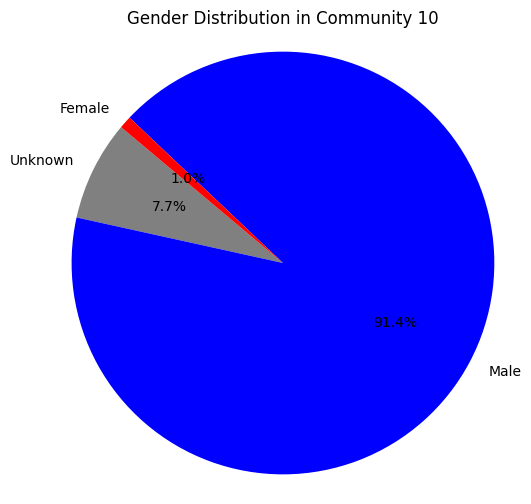

Community 11:
Gender distribution: Unknown=19, Male=132, Female=5
Chi-squared: 186.50, p-value: 0.0000
Significant gender distribution found.



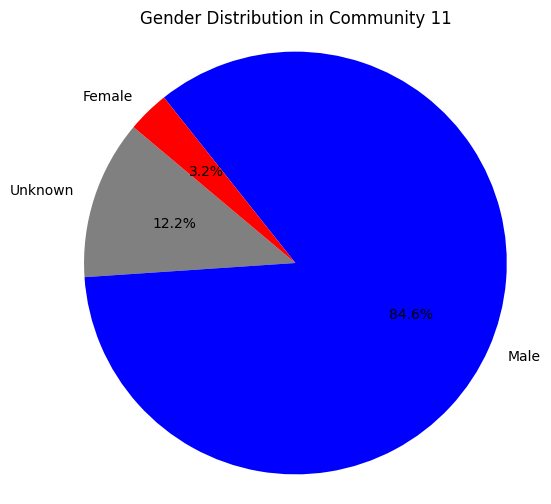

Community 12:
Gender distribution: Unknown=11, Male=82, Female=2
Chi-squared: 121.28, p-value: 0.0000
Significant gender distribution found.



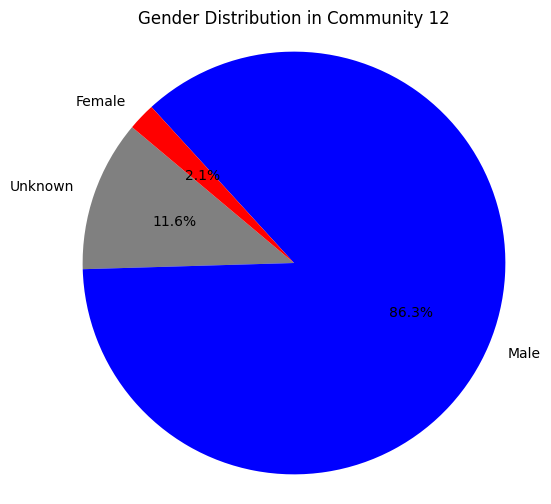

Community 13:
Gender distribution: Unknown=2, Male=85, Female=0
Chi-squared: 162.28, p-value: 0.0000
Significant gender distribution found.



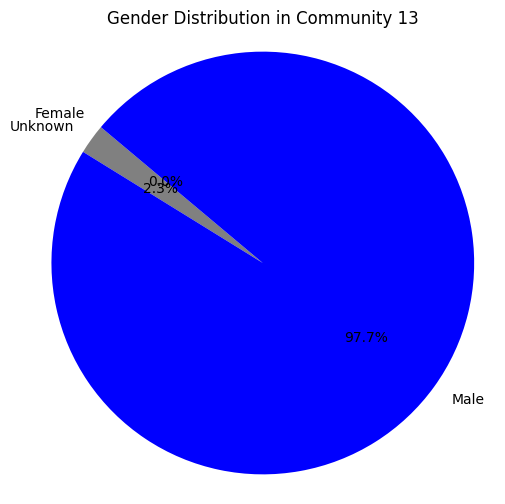

Community 0:
Gender distribution: Unknown=12, Male=53, Female=0
Chi-squared: 71.29, p-value: 0.0000
Significant gender distribution found.



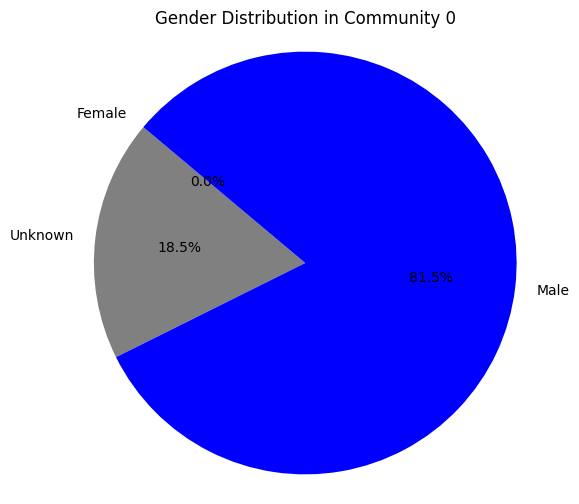

Community 16:
Gender distribution: Unknown=8, Male=77, Female=0
Chi-squared: 126.52, p-value: 0.0000
Significant gender distribution found.



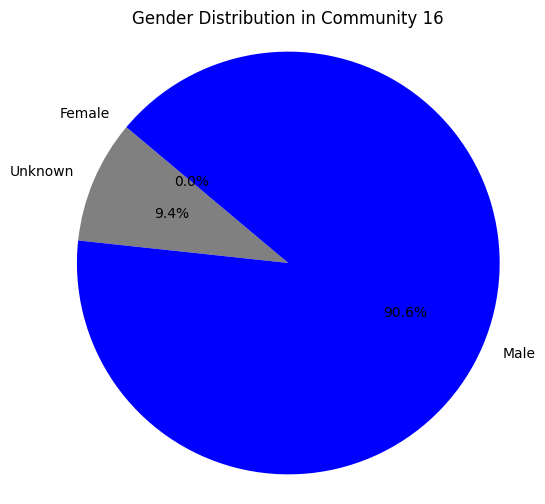

Community 15:
Gender distribution: Unknown=22, Male=87, Female=0
Chi-squared: 112.64, p-value: 0.0000
Significant gender distribution found.



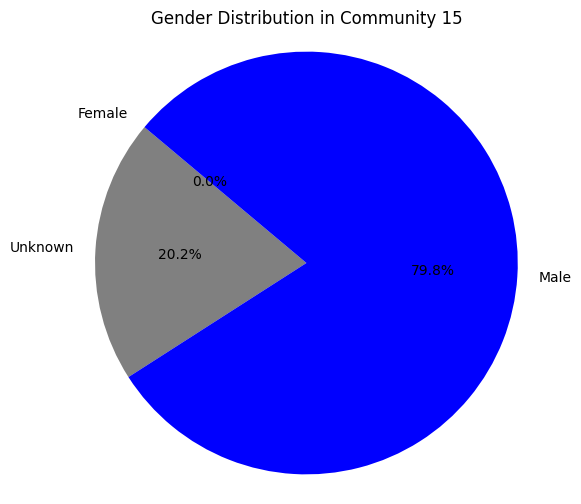

Community 6:
Gender distribution: Unknown=22, Male=137, Female=0
Chi-squared: 204.26, p-value: 0.0000
Significant gender distribution found.



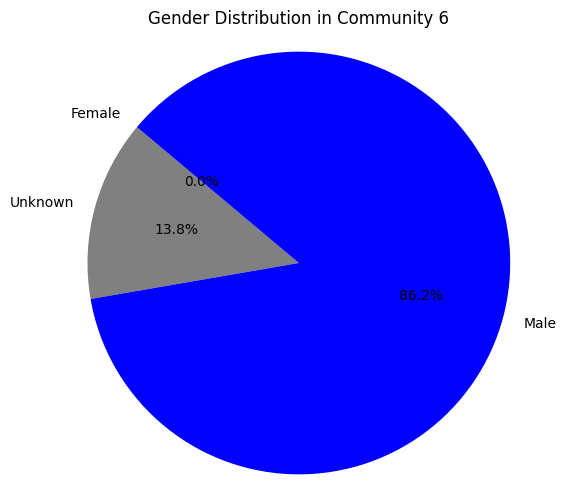

Community 8:
Gender distribution: Unknown=7, Male=72, Female=1
Chi-squared: 116.27, p-value: 0.0000
Significant gender distribution found.



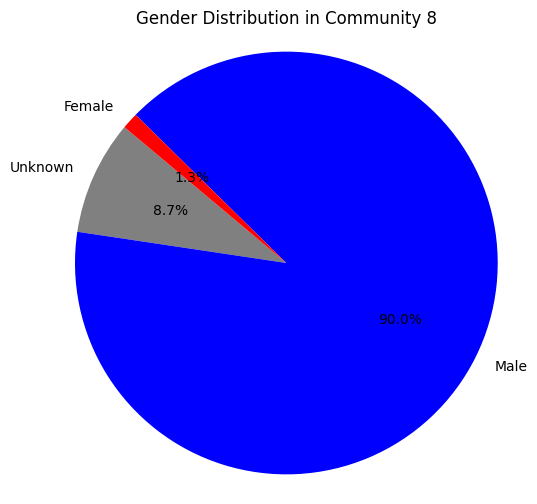

Campus Vassar85.gml
Community 0:
Gender distribution: Unknown=7, Male=358, Female=235
Chi-squared: 317.19, p-value: 0.0000
Significant gender distribution found.



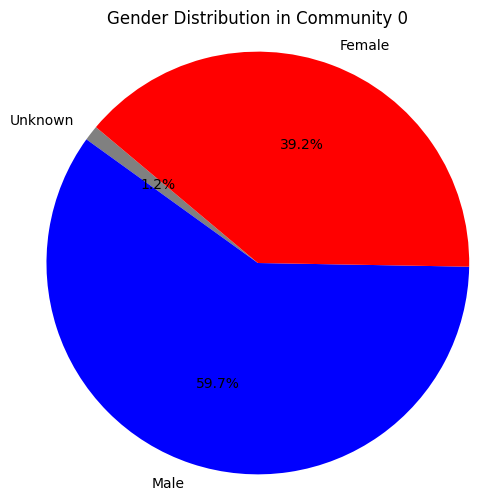

Community 3:
Gender distribution: Unknown=130, Male=602, Female=405
Chi-squared: 296.59, p-value: 0.0000
Significant gender distribution found.



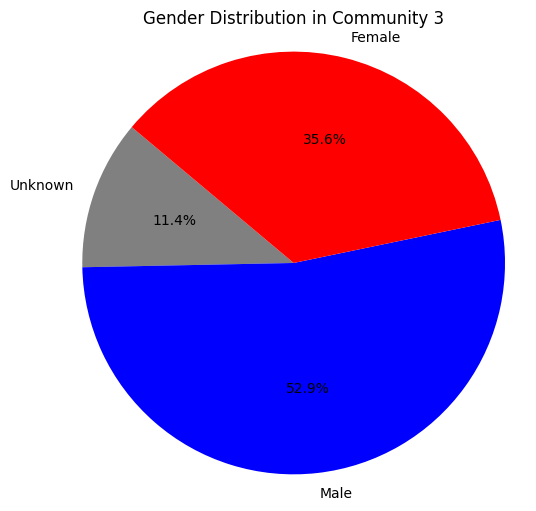

Community 1:
Gender distribution: Unknown=51, Male=350, Female=203
Chi-squared: 222.04, p-value: 0.0000
Significant gender distribution found.



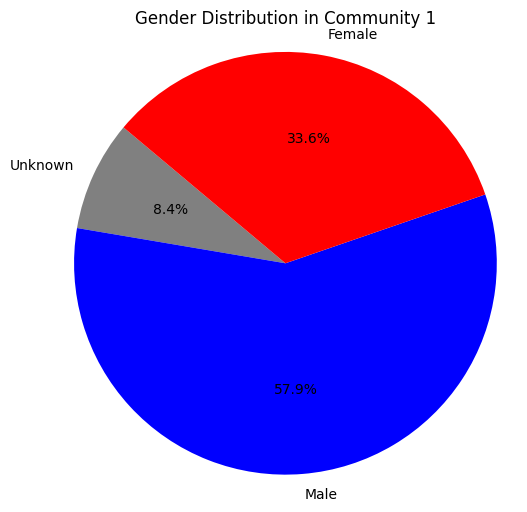

Community 2:
Gender distribution: Unknown=66, Male=266, Female=200
Chi-squared: 117.13, p-value: 0.0000
Significant gender distribution found.



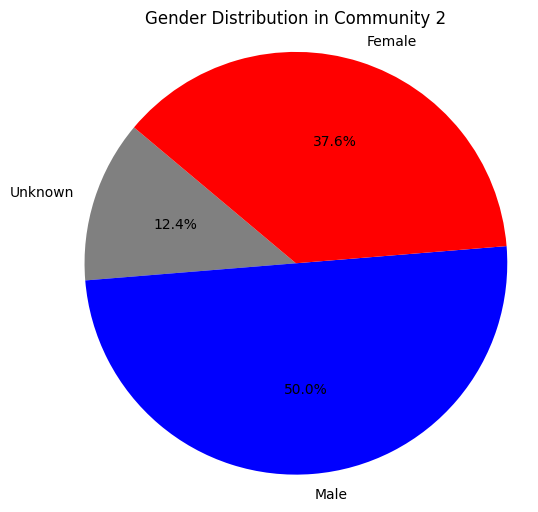

Community 5:
Gender distribution: Unknown=22, Male=114, Female=55
Chi-squared: 68.24, p-value: 0.0000
Significant gender distribution found.



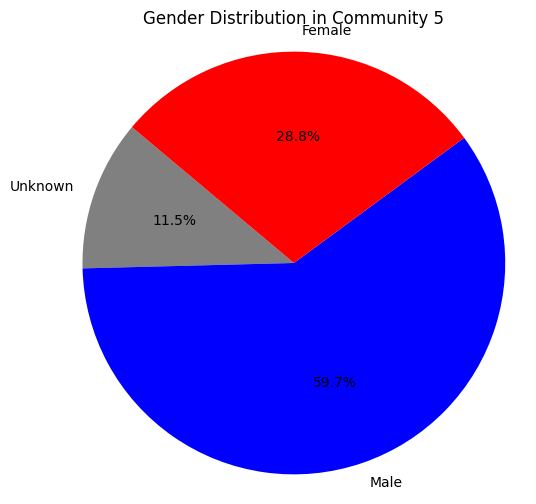

Community 4:
Gender distribution: Unknown=1, Male=3, Female=0
Chi-squared: 3.50, p-value: 0.1738
No significant gender distribution found.



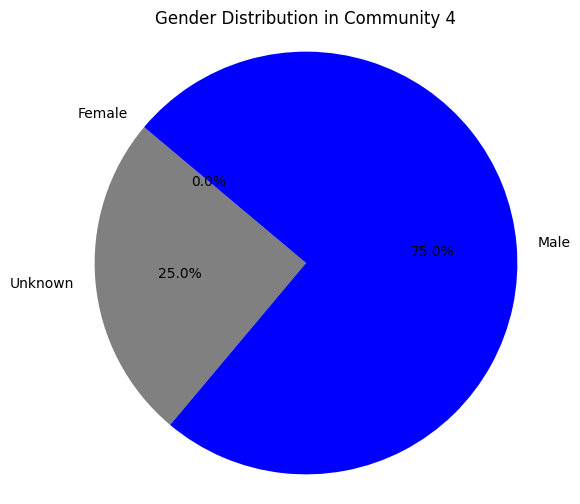

In [160]:
import matplotlib.pyplot as plt
import scipy.stats as stats
community_genders = total_community

for i in range(len(community_genders)):
    # 对每个社区进行显著性检验和可视化
    print(f"Campus {file_names_list[i]}")
    community_gender = community_genders[i]
    for community_id, gender_list in community_gender.items():
        # 计算每个性别的数量
        unknown_count = gender_list.count(0)
        male_count = gender_list.count(1)
        female_count = gender_list.count(2)

        # 性别数量列表
        counts = [unknown_count, male_count, female_count]

        total = sum(counts)
        expected = [total / 3] * 3  # 假设性别分布均匀

        # 进行卡方检验
        chi2, p = stats.chisquare(counts, f_exp=expected)

        print(f"Community {community_id}:")
        print(f"Gender distribution: Unknown={unknown_count}, Male={male_count}, Female={female_count}")
        print(f"Chi-squared: {chi2:.2f}, p-value: {p:.4f}")

        # 根据p值判断性别分布是否随机
        if p < 0.05:
            print("Significant gender distribution found.\n")
        else:
            print("No significant gender distribution found.\n")

        # 可视化
        labels = ['Unknown', 'Male', 'Female']
        colors = ['grey', 'blue', 'red']

        plt.figure(figsize=(6, 6))
        plt.pie(counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
        plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        plt.title(f"Gender Distribution in Community {community_id}")
        plt.show()
